In [1]:
import os

current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
os.chdir(parent_directory)


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quiniela import io
import datetime
from statistics import mean

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import LabelEncoder

# Models to try
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.ensemble import VotingClassifier

First of all, we prepare the dataset to train our model. To see whether our model is good or no, we train it until season 2019-2020, so we can test our model with the whole season 2020-2021 and look its predictions outside the dataset of training

In [6]:
def encoder_teams():
    data = io.load_historical_data(("2010-2011", "2011-2012", "2012-2013", "2013-2014", "2014-2015",
                                    "2015-2016", "2016-2017", "2017-2018", "2018-2019", "2019-2020",
                                    "2020-2021", "2021-2022"))
    # We just need the teams from the training and the prediction
    team_names = data['home_team'].unique()
    team_ids = [i for i in range(len(team_names))]
    
    return team_names, team_ids

In [7]:


def preparing_training_dataset_1():
    data = io.load_historical_data(("2010-2011", "2011-2012", "2012-2013", "2013-2014", "2014-2015", "2015-2016", "2016-2017", "2017-2018", "2018-2019", "2019-2020"))
    data[['local_goals', 'visitor_goals']] = data['score'].str.split(':', expand=True).astype(float)
    data['winner'] = data.apply(determine_winner, axis=1)
    data['goal_difference'] = data['local_goals'] - data['visitor_goals']
    data['weekday'] = data['date'].apply(weekday_match)
    
    home_team_df = data.copy()
    home_team_df['team'], home_team_df['rival'], home_team_df['condition'] = home_team_df['home_team'], home_team_df['away_team'], 'local'
    away_team_df = data.copy()
    away_team_df['team'], away_team_df['rival'], away_team_df['condition']= away_team_df['away_team'], away_team_df['home_team'], 'visitor'
    
    matches_data = pd.concat([home_team_df, away_team_df], ignore_index=True).sort_values(by=['season', 'division', 'team', 'matchday'])
    matches_data.reset_index(drop=True, inplace=True)
    
    matches_data['GF_match'] = matches_data.apply(lambda row: row['local_goals'] if row['condition'] == 'local' else row['visitor_goals'], axis=1)
    matches_data['GA_match'] = matches_data.apply(lambda row: row['visitor_goals'] if row['condition'] == 'local' else row['local_goals'], axis=1)
    matches_data['GD_match'] = matches_data['GF_match'] - matches_data['GA_match']
    matches_data['W_match'] = ((matches_data['winner'] == 'Local') & (matches_data['condition'] == 'local')) | ((matches_data['winner'] == 'Visitor') & (matches_data['condition'] == 'visitor'))
    matches_data['L_match'] = ((matches_data['winner'] == 'Visitor') & (matches_data['condition'] == 'local')) | ((matches_data['winner'] == 'Local') & (matches_data['condition'] == 'visitor'))
    matches_data['T_match'] = (matches_data['winner'] == 'Tie')
    matches_data['match_result'] = matches_data.apply(match_result, axis=1)
    matches_data['last_match_result_1'] = matches_data.groupby(['season', 'team'])['match_result'].shift(1)
    matches_data['last_match_result_2'] = matches_data.groupby(['season', 'team'])['match_result'].shift(2)
    matches_data['last_match_result_3'] = matches_data.groupby(['season', 'team'])['match_result'].shift(3)
    matches_data['last_match_result_4'] = matches_data.groupby(['season', 'team'])['match_result'].shift(4)
    matches_data['last_match_result_5'] = matches_data.groupby(['season', 'team'])['match_result'].shift(5)
    matches_data['last_5_results_local'] = matches_data[['last_match_result_1', 'last_match_result_2', 'last_match_result_3', 
                                                'last_match_result_4', 'last_match_result_5']].values.tolist()

    matches_data['GF'] = matches_data.groupby(['season', 'team'])['GF_match'].cumsum()
    matches_data['GA'] = matches_data.groupby(['season', 'team'])['GA_match'].cumsum()
    matches_data['W'] = matches_data.groupby(['season', 'team'])['W_match'].cumsum()
    matches_data['L'] = matches_data.groupby(['season', 'team'])['L_match'].cumsum()
    matches_data['T'] = matches_data.groupby(['season', 'team'])['T_match'].cumsum()
    
    final_ranking = matches_data.reset_index()
    final_ranking['GD'] = final_ranking['GF'] - final_ranking['GA']
    final_ranking['Pts'] = final_ranking['W'] * 3 + final_ranking['T']
    final_ranking = final_ranking.sort_values(by=['season', 'division', 'matchday', 'Pts', 'GD'], ascending=[False, True, True, False, False])
    final_ranking.reset_index(drop=True, inplace=True)
    final_ranking['rank'] = final_ranking.groupby(['season', 'division', 'matchday'])['Pts'].rank(ascending=False, method='first').astype(int)
    
    final_ranking = final_ranking[['season', 'division', 'matchday', 'weekday', 'time', 'rank', 'team', 'rival', 'condition', 'winner', 'GF_match', 'GA_match', 'GD_match', 'GF', 'GA', 'GD', 'W', 'L', 'T', 'Pts', 'last_5_results_local']]
    ### Prepare numerical data
    #season
    seasons_string = final_ranking['season'].unique()
    seasons_list = list(reversed(range(2010, 2020)))
    final_ranking['season'] = final_ranking['season'].replace(seasons_string, seasons_list)
    #time
    final_ranking['time'] = final_ranking['time'].apply(numerical_time)
    #team / rival
    team_names, team_ids = encoder_teams()
    final_ranking[['team', 'rival']] = final_ranking[['team', 'rival']].replace(team_names, team_ids)
    
    #winner --> 0: Local, 1: Tie, 2:Visitor
    final_ranking['winner'] = final_ranking['winner'].replace(['Local', 'Tie', 'Visitor'], [0, 1, 2])
    #last 5 results
    final_ranking['last_5_results_local'] = final_ranking['last_5_results_local'].apply(numerical_last_results_local)
    mapping = final_ranking.groupby(['season', 'matchday']).apply(lambda x: dict(zip(x['team'], x['last_5_results_local']))).to_dict()
    final_ranking['last_5_results_rival'] = final_ranking.apply(lambda row: mapping.get((row['season'], row['matchday']), {}).get(row['rival'], None), axis=1)
    # The matches are repeated: Drop when condition is Visitor
    final_ranking = final_ranking.loc[final_ranking['condition'] == 'local']

    final_ranking.to_excel('./analysis/training_dataset_1.xlsx')
    return final_ranking


# Aux function
def weekday_match(date):
    month, day, year = map(int, date.split('/'))
    year += 2000
    
    n_weekday = datetime.date(year, month, day).weekday()
    return n_weekday

def determine_winner(row):
    if row['local_goals'] > row['visitor_goals']:
        return 'Local'
    elif row['local_goals'] < row['visitor_goals']:
        return 'Visitor'
    else:
        return 'Tie'
    
def match_result(row):
    if row['W_match'] == True:
        return 'W'
    elif row['L_match'] == True:
        return 'L'
    elif row['T_match'] == True:
        return 'T'
    
def numerical_time(time_string):
    if time_string is None:
        time_string = "12:00 AM"
    time_parts = datetime.datetime.strptime(time_string, "%I:%M %p")
    time_num = time_parts.hour + time_parts.minute / 60
    return time_num

def numerical_last_results_local(last_results_list):
    total = 0
    for result in last_results_list:
        if result == 'W':
            total += 3
        elif result == 'T':
            total += 1
        else:
            total += -3
    return total

dataset_1 = preparing_training_dataset_1()
print(dataset_1)

       season  division  matchday  weekday  time  rank  team  rival condition  \
2        2019         1         1        6  17.0     3    30      2     local   
3        2019         1         1        4  21.0     4    13     10     local   
4        2019         1         1        6  22.0     5     9     14     local   
6        2019         1         1        5  20.0     7     8     26     local   
10       2019         1         1        5  19.0    11    11      4     local   
...       ...       ...       ...      ...   ...   ...   ...    ...       ...   
16829    2010         2        42        5  20.0    12    41     22     local   
16832    2010         2        42        5  18.0    15    28     44     local   
16836    2010         2        42        5  18.0    19    35     43     local   
16838    2010         2        42        5  18.0    21    34     39     local   
16839    2010         2        42        5  18.0    22    36     32     local   

       winner  ...  GD_matc

Now, we split the data between the training one and testing one. Also, decide the features that will train the model.
After some tries and errors, we have found that the best features to train the model are the following ones:

In [8]:
features = ['season', 'division', 'matchday', 'weekday', 'time', 'team', 'rival', 'last_5_results_local','last_5_results_rival']
target = "winner"
X, y = dataset_1[features], dataset_1[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

We will see which model is better to predict our results:
- GradientBoostingRegressor
- RandomForestClassifier
- BaggingClassifier
- Combination: VotingClassifier

We will also try each one with different hyperparameters. Also, we will compare how much time it require to train each model, so we can take this into account.

GRADIENT BOOSTING

In [9]:
gb_model_1 = GradientBoostingClassifier()
gb_model_1.fit(X_train, y_train)
gb_model_1_y_pred = gb_model_1.predict(X_test)
print(f"RMSE: {mean_squared_error(y_test, gb_model_1_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, gb_model_1_y_pred)}")
print(f"R^2: {r2_score(y_test, gb_model_1_y_pred)}")

RMSE: 1.09197026052967
MAPE: 401151985810911.56
R^2: -0.7371143474041706


In [10]:
gb_model_2 = GradientBoostingClassifier(n_estimators=200, max_depth=6, random_state=15)
gb_model_2.fit(X_train, y_train)
gb_model_2_y_pred = gb_model_2.predict(X_test)
print(f"RMSE: {mean_squared_error(y_test, gb_model_2_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, gb_model_2_y_pred)}")
print(f"R^2: {r2_score(y_test, gb_model_2_y_pred)}")

RMSE: 1.0727680802108346
MAPE: 922649567365096.0
R^2: -0.6765575723452601


In [11]:
gb_model_3 = GradientBoostingClassifier(n_estimators=300, max_depth=15, random_state=15)
gb_model_3.fit(X_train, y_train)
gb_model_3_y_pred = gb_model_3.predict(X_test)
print(f"RMSE: {mean_squared_error(y_test, gb_model_3_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, gb_model_3_y_pred)}")
print(f"R^2: {r2_score(y_test, gb_model_3_y_pred)}")

RMSE: 1.0881569329323948
MAPE: 954741726229968.9
R^2: -0.7250029923923884


RANDOM FOREST

In [12]:
rf_model_1 = RandomForestClassifier()
rf_model_1.fit(X_train, y_train)
rf_model_1_y_pred = rf_model_1.predict(X_test)
print(f"RMSE: {mean_squared_error(y_test, rf_model_1_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, rf_model_1_y_pred)}")
print(f"R^2: {r2_score(y_test, rf_model_1_y_pred)}")

RMSE: 1.1044070646145587
MAPE: 839744823630841.0
R^2: -0.7769087995857402


In [13]:
rf_model_2 = RandomForestClassifier(n_estimators=200, max_depth=6, random_state=15)
rf_model_2.fit(X_train, y_train)
rf_model_2_y_pred = rf_model_2.predict(X_test)
print(f"RMSE: {mean_squared_error(y_test, rf_model_2_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, rf_model_2_y_pred)}")
print(f"R^2: {r2_score(y_test, rf_model_2_y_pred)}")

RMSE: 1.130184017976414
MAPE: 197901646333383.3
R^2: -0.8608231878816588


In [14]:
rf_model_3 = RandomForestClassifier(n_estimators=300, max_depth=15, random_state=15)
rf_model_3.fit(X_train, y_train)
rf_model_3_y_pred = rf_model_3.predict(X_test)
print(f"RMSE: {mean_squared_error(y_test, rf_model_3_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, rf_model_3_y_pred)}")
print(f"R^2: {r2_score(y_test, rf_model_3_y_pred)}")

RMSE: 1.1030620305451564
MAPE: 636494484153312.6
R^2: -0.7725833156529609


BAGGING CLASSIFIER

In [15]:
bg_model_1 = BaggingClassifier()
bg_model_1.fit(X_train, y_train)
bg_model_1_y_pred = bg_model_1.predict(X_test)
print(f"RMSE: {mean_squared_error(y_test, bg_model_1_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, bg_model_1_y_pred)}")
print(f"R^2: {r2_score(y_test, bg_model_1_y_pred)}")

RMSE: 1.1089679780079453
MAPE: 1072412975401169.4
R^2: -0.7916154449571897


In [16]:
bg_model_2 = BaggingClassifier(n_estimators=200, random_state=15)
bg_model_2.fit(X_train, y_train)
bg_model_2_y_pred = bg_model_2.predict(X_test)
print(f"RMSE: {mean_squared_error(y_test, bg_model_2_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, bg_model_2_y_pred)}")
print(f"R^2: {r2_score(y_test, bg_model_2_y_pred)}")

RMSE: 1.1095033234303933
MAPE: 901254794788514.0
R^2: -0.7933456385303015


In [17]:
bg_model_3 = BaggingClassifier(n_estimators=300, random_state=15)
bg_model_3.fit(X_train, y_train)
bg_model_3_y_pred = bg_model_3.predict(X_test)
print(f"RMSE: {mean_squared_error(y_test, bg_model_3_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, bg_model_3_y_pred)}")
print(f"R^2: {r2_score(y_test, bg_model_3_y_pred)}")

RMSE: 1.1143098585257158
MAPE: 914626527648877.8
R^2: -0.808917380688307


VOTING CLASSIFIER
To decide which 3 of each model is better to use in our voting classifier, foremost, we will study these 9 models to see which ones of each are the best for our data

So, now we prepare the dataset that we will use to predict (season 2020-2021). We will try to predict every match of every matchday and compare the predictions with the reality. Therefore, we will see which models are better to use.

In [18]:
def preparing__predicting_dataset_1():
    data = io.load_historical_data("all")
    data = data.loc[data['season'] == "2020-2021"]
    data[['local_goals', 'visitor_goals']] = data['score'].str.split(':', expand=True).astype(float)
    data['winner'] = data.apply(determine_winner, axis=1)
    data['goal_difference'] = data['local_goals'] - data['visitor_goals']
    data['weekday'] = data['date'].apply(weekday_match)
    
    home_team_df = data.copy()
    home_team_df['team'], home_team_df['rival'], home_team_df['condition'] = home_team_df['home_team'], home_team_df['away_team'], 'local'
    away_team_df = data.copy()
    away_team_df['team'], away_team_df['rival'], away_team_df['condition']= away_team_df['away_team'], away_team_df['home_team'], 'visitor'
    
    matches_data = pd.concat([home_team_df, away_team_df], ignore_index=True).sort_values(by=['season', 'division', 'team', 'matchday'])
    matches_data.reset_index(drop=True, inplace=True)
    
    matches_data['GF_match'] = matches_data.apply(lambda row: row['local_goals'] if row['condition'] == 'local' else row['visitor_goals'], axis=1)
    matches_data['GA_match'] = matches_data.apply(lambda row: row['visitor_goals'] if row['condition'] == 'local' else row['local_goals'], axis=1)
    matches_data['GD_match'] = matches_data['GF_match'] - matches_data['GA_match']
    matches_data['W_match'] = ((matches_data['winner'] == 'Local') & (matches_data['condition'] == 'local')) | ((matches_data['winner'] == 'Visitor') & (matches_data['condition'] == 'visitor'))
    matches_data['L_match'] = ((matches_data['winner'] == 'Visitor') & (matches_data['condition'] == 'local')) | ((matches_data['winner'] == 'Local') & (matches_data['condition'] == 'visitor'))
    matches_data['T_match'] = (matches_data['winner'] == 'Tie')
    matches_data['match_result'] = matches_data.apply(match_result, axis=1)
    matches_data['last_match_result_1'] = matches_data.groupby(['season', 'team'])['match_result'].shift(1)
    matches_data['last_match_result_2'] = matches_data.groupby(['season', 'team'])['match_result'].shift(2)
    matches_data['last_match_result_3'] = matches_data.groupby(['season', 'team'])['match_result'].shift(3)
    matches_data['last_match_result_4'] = matches_data.groupby(['season', 'team'])['match_result'].shift(4)
    matches_data['last_match_result_5'] = matches_data.groupby(['season', 'team'])['match_result'].shift(5)
    matches_data['last_5_results_local'] = matches_data[['last_match_result_1', 'last_match_result_2', 'last_match_result_3', 
                                                'last_match_result_4', 'last_match_result_5']].values.tolist()

    matches_data['GF'] = matches_data.groupby(['season', 'team'])['GF_match'].cumsum()
    matches_data['GA'] = matches_data.groupby(['season', 'team'])['GA_match'].cumsum()
    matches_data['W'] = matches_data.groupby(['season', 'team'])['W_match'].cumsum()
    matches_data['L'] = matches_data.groupby(['season', 'team'])['L_match'].cumsum()
    matches_data['T'] = matches_data.groupby(['season', 'team'])['T_match'].cumsum()
    
    final_ranking = matches_data.reset_index()
    final_ranking['GD'] = final_ranking['GF'] - final_ranking['GA']
    final_ranking['Pts'] = final_ranking['W'] * 3 + final_ranking['T']
    final_ranking = final_ranking.sort_values(by=['season', 'division', 'matchday', 'Pts', 'GD'], ascending=[False, True, True, False, False])
    final_ranking.reset_index(drop=True, inplace=True)
    final_ranking['rank'] = final_ranking.groupby(['season', 'division', 'matchday'])['Pts'].rank(ascending=False, method='first').astype(int)
    
    final_ranking = final_ranking[['season', 'division', 'matchday', 'weekday', 'time', 'rank', 'team', 'rival', 'condition', 'winner', 'GF_match', 'GA_match', 'GD_match', 'GF', 'GA', 'GD', 'W', 'L', 'T', 'Pts', 'last_5_results_local']]
    ### Prepare numerical data
    #season
    final_ranking['season'] = final_ranking['season'].replace("2020-2021", 2020)
    #time
    final_ranking['time'] = final_ranking['time'].apply(numerical_time)
    #team / rival
    team_names, team_ids = encoder_teams()
    final_ranking[['team', 'rival']] = final_ranking[['team', 'rival']].replace(team_names, team_ids)
    
    #winner --> 0: Local, 1: Tie, 2:Visitor
    final_ranking['winner'] = final_ranking['winner'].replace(['Local', 'Tie', 'Visitor'], [0, 1, 2])
    #last 5 results
    final_ranking['last_5_results_local'] = final_ranking['last_5_results_local'].apply(numerical_last_results_local)
    mapping = final_ranking.groupby(['season', 'matchday']).apply(lambda x: dict(zip(x['team'], x['last_5_results_local']))).to_dict()
    final_ranking['last_5_results_rival'] = final_ranking.apply(lambda row: mapping.get((row['season'], row['matchday']), {}).get(row['rival'], None), axis=1)
    # The matches are repeated: Drop when condition is Visitor
    final_ranking = final_ranking.loc[final_ranking['condition'] == 'local']

    final_ranking.to_excel('./analysis/predicting_dataset_1.xlsx')
    return final_ranking


# Aux function
def weekday_match(date):
    month, day, year = map(int, date.split('/'))
    year += 2000
    
    n_weekday = datetime.date(year, month, day).weekday()
    return n_weekday

def determine_winner(row):
    if row['local_goals'] > row['visitor_goals']:
        return 'Local'
    elif row['local_goals'] < row['visitor_goals']:
        return 'Visitor'
    else:
        return 'Tie'
    
def match_result(row):
    if row['W_match'] == True:
        return 'W'
    elif row['L_match'] == True:
        return 'L'
    elif row['T_match'] == True:
        return 'T'
    
def numerical_time(time_string):
    if time_string is None:
        time_string = "12:00 AM"
    time_parts = datetime.datetime.strptime(time_string, "%I:%M %p")
    time_num = time_parts.hour + time_parts.minute / 60
    return time_num

def numerical_last_results_local(last_results_list):
    total = 0
    for result in last_results_list:
        if result == 'W':
            total += 3
        elif result == 'T':
            total += 1
        else:
            total += -3
    return total

dataset_predict_1 = preparing__predicting_dataset_1()

This dataset contains the results of 38 matchdays for division 1 and 42 matchdays for division 2. We will study the prediction capacity for division 1. We take this decision because this model is oriented to predict results of division 1 only. However, it should really work "equally" for division 2, even though we won't neither check nor prove it.

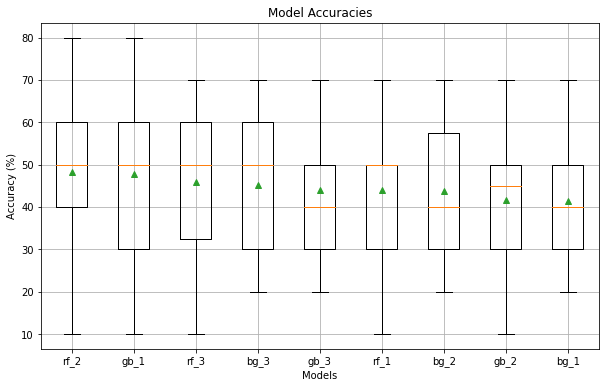

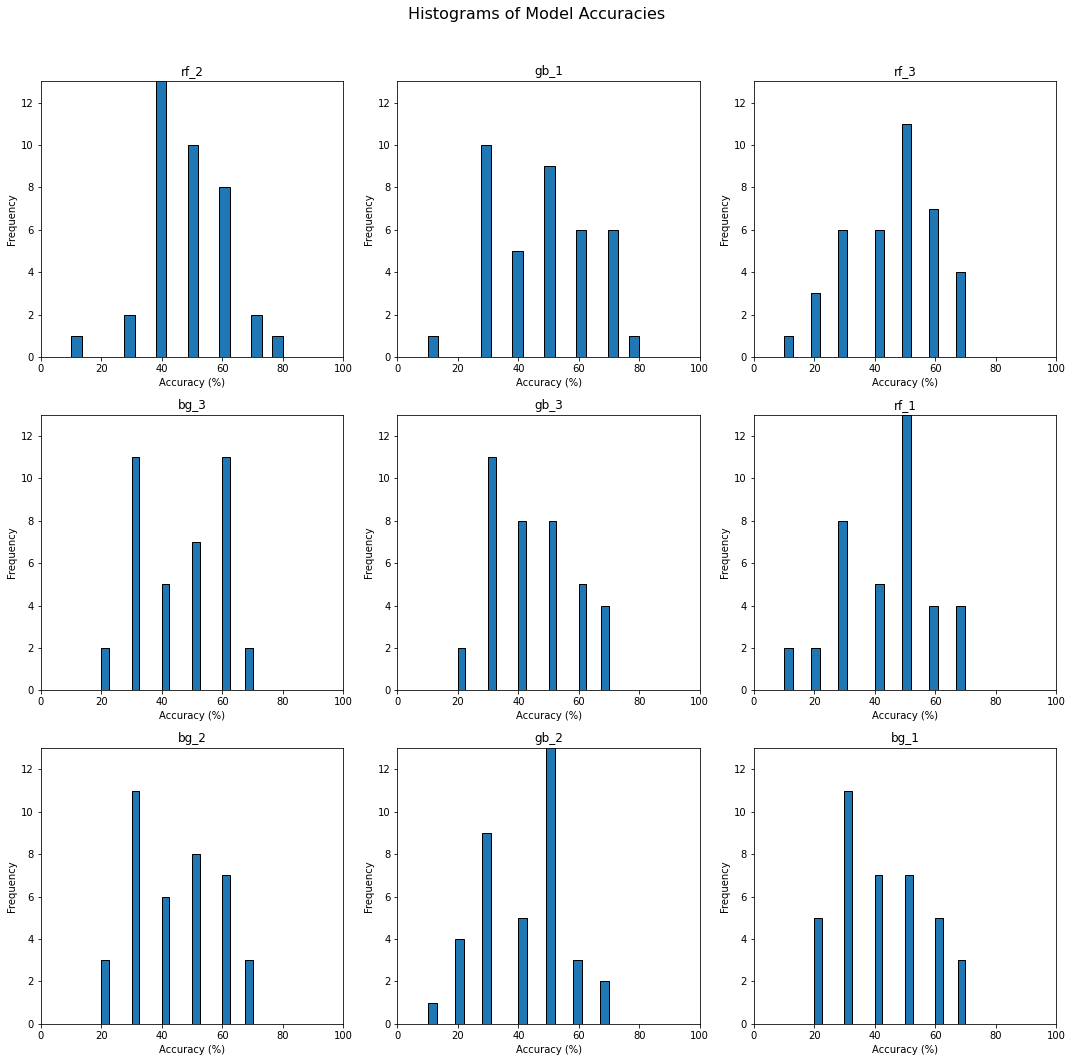

In [19]:
gb_1_accuracies = []
gb_2_accuracies = []
gb_3_accuracies = []
rf_1_accuracies = []
rf_2_accuracies = []
rf_3_accuracies = []
bg_1_accuracies = []
bg_2_accuracies = []
bg_3_accuracies = []

div = 1
matchdays_1 = [i + 1 for i in range(38)]
for matchday in matchdays_1:
    matchday_predict = dataset_predict_1.loc[(dataset_predict_1['division'] == div) & (dataset_predict_1['matchday'] == matchday)]
    X_predict, y_predict = matchday_predict[features], matchday_predict[target]
    gb_1_y_pred = gb_model_1.predict(X_predict)
    gb_2_y_pred = gb_model_2.predict(X_predict)
    gb_3_y_pred = gb_model_3.predict(X_predict)
    rf_1_y_pred = rf_model_1.predict(X_predict)
    rf_2_y_pred = rf_model_2.predict(X_predict)
    rf_3_y_pred = rf_model_3.predict(X_predict)
    bg_1_y_pred = bg_model_1.predict(X_predict)
    bg_2_y_pred = bg_model_2.predict(X_predict)
    bg_3_y_pred = bg_model_3.predict(X_predict)
    
    real_results = y_predict.to_list()
    gb_1_predictions = gb_1_y_pred.tolist()
    gb_2_predictions = gb_2_y_pred.tolist()
    gb_3_predictions = gb_3_y_pred.tolist()
    rf_1_predictions = rf_1_y_pred.tolist()
    rf_2_predictions = rf_2_y_pred.tolist()
    rf_3_predictions = rf_3_y_pred.tolist()
    bg_1_predictions = bg_1_y_pred.tolist()
    bg_2_predictions = bg_2_y_pred.tolist()
    bg_3_predictions = bg_3_y_pred.tolist()
    
    total_matches = len(real_results)
    gb_1_total_predicted = 0
    gb_2_total_predicted = 0
    gb_3_total_predicted = 0
    rf_1_total_predicted = 0
    rf_2_total_predicted = 0
    rf_3_total_predicted = 0
    bg_1_total_predicted = 0
    bg_2_total_predicted = 0
    bg_3_total_predicted = 0
    
    for i in range(total_matches):
        if real_results[i] == gb_1_predictions[i]:
            gb_1_total_predicted += 1
        if real_results[i] == gb_2_predictions[i]:
            gb_2_total_predicted += 1
        if real_results[i] == gb_3_predictions[i]:
            gb_3_total_predicted += 1
        if real_results[i] == rf_1_predictions[i]:
            rf_1_total_predicted += 1
        if real_results[i] == rf_2_predictions[i]:
            rf_2_total_predicted += 1
        if real_results[i] == rf_3_predictions[i]:
            rf_3_total_predicted += 1
        if real_results[i] == bg_1_predictions[i]:
            bg_1_total_predicted += 1
        if real_results[i] == bg_2_predictions[i]:
            bg_2_total_predicted += 1
        if real_results[i] == bg_3_predictions[i]:
            bg_3_total_predicted += 1
            
    gb_1_accuracies.append(gb_1_total_predicted * 100 / total_matches)
    gb_2_accuracies.append(gb_2_total_predicted * 100 / total_matches)
    gb_3_accuracies.append(gb_3_total_predicted * 100 / total_matches)
    rf_1_accuracies.append(rf_1_total_predicted * 100 / total_matches)
    rf_2_accuracies.append(rf_2_total_predicted * 100 / total_matches)
    rf_3_accuracies.append(rf_3_total_predicted * 100 / total_matches)
    bg_1_accuracies.append(bg_1_total_predicted * 100 / total_matches)
    bg_2_accuracies.append(bg_2_total_predicted * 100 / total_matches)
    bg_3_accuracies.append(bg_3_total_predicted * 100 / total_matches)

# Plot means and variances
models = ['gb_1', 'gb_2', 'gb_3', 'rf_1', 'rf_2', 'rf_3', 'bg_1', 'bg_2', 'bg_3']
accuracies = [gb_1_accuracies, gb_2_accuracies, gb_3_accuracies,
                rf_1_accuracies, rf_2_accuracies, rf_3_accuracies,
                bg_1_accuracies, bg_2_accuracies, bg_3_accuracies]

mean_accuracies = [mean(acc) for acc in accuracies]
# Sort models based on mean accuracy
sorted_indices = sorted(range(len(mean_accuracies)), key=lambda k: mean_accuracies[k], reverse=True)
sorted_models = [models[i] for i in sorted_indices]
sorted_accuracies = [accuracies[i] for i in sorted_indices]

# Create a box plot
plt.figure(figsize=(10, 6))
plt.boxplot(sorted_accuracies, labels=sorted_models, showmeans=True)
plt.title('Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.grid(True)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
fig.suptitle('Histograms of Model Accuracies', fontsize=16)

for i in range(3):
    for j in range(3):
        model_index = i * 3 + j
        axes[i, j].hist(sorted_accuracies[model_index], bins=20, edgecolor='black')
        axes[i, j].set_title(sorted_models[model_index])
        axes[i, j].set_xlabel('Accuracy (%)')
        axes[i, j].set_ylabel('Frequency')
        axes[i, j].set_xlim(0, 100)
        axes[i, j].set_ylim(0, 13)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])


plt.show()
    

We can make some conclusions looking at both plots.
The models with higher means are gb_1, rf_2 and rf_3. They are also quite fast to train (1.8, 0.7 and 3.2 seconds respectively). However, both gb_1 and rf_2 tend to do some bad predictions, even though at least they rarely happen. In general, both make good predictions, above 40-50% usually. In contrast, rf_3 have more variety, but the mean is good and the predictions are over 30% almost always. It has even a relatively low frequency of really good predictions, around 80 and 90%. 
The others doesn't seem to be better. They all have high frequency of worse predictions (less than 40%), and maybe the only ones that not are bg_3 and gb_2. However, the predictions that rf_3 make pretty well, these two mentioned makes regular predictions.

This analysis is at first view. If we really want to combine it with VotingClassifier, it's good to see whether they can complement each other. Where one fails, the other two have better accuracies. 
Therefore, let's analyze where they (gb_1, rf_2 and rf_3) make better and worse predictions and which features they depend most on. 

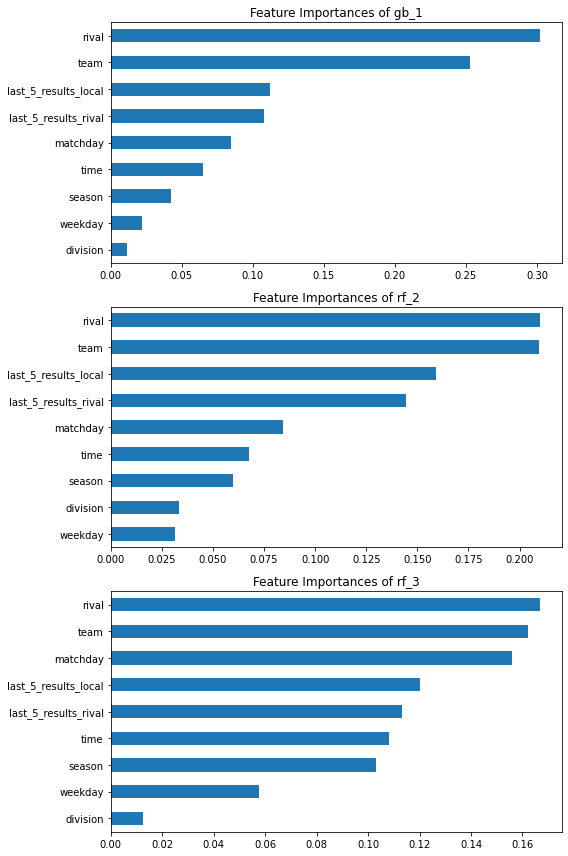

In [20]:
gb_1_importances = pd.Series(gb_model_1.feature_importances_, index=features)
rf_2_importances = pd.Series(rf_model_2.feature_importances_, index=features)
rf_3_importances = pd.Series(rf_model_3.feature_importances_, index=features)

# Create a 3x1 subplot
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 12))

# Plot the first subplot (gb_1)
gb_1_importances.sort_values(ascending=True).plot(kind="barh", ax=axes[0])
axes[0].set_title('Feature Importances of gb_1')

# Plot the second subplot (rf_2)
rf_2_importances.sort_values(ascending=True).plot(kind="barh", ax=axes[1])
axes[1].set_title('Feature Importances of rf_2')

# Plot the third subplot (rf_3)
rf_3_importances.sort_values(ascending=True).plot(kind="barh", ax=axes[2])
axes[2].set_title('Feature Importances of rf_3')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

We can see that they depend the most on the same features (teams playing and last results). This should be expected. In fact, gb_1 and rf_2 have more or less the same dependency. On the other hand, rf_3 distribute it more equitably. 
Now let's see where they predict better and worse.

A confusion matrix provides insights into the number of true positives, true negatives, false positives, and false negatives.

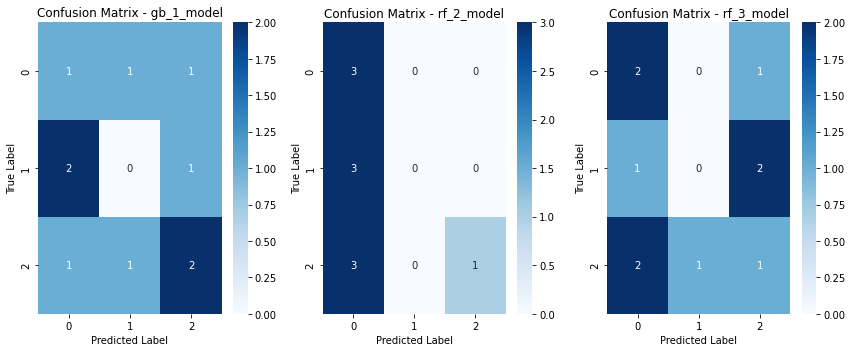

In [21]:

from sklearn.metrics import confusion_matrix
import seaborn as sns

gb_1_cm = confusion_matrix(y_predict, gb_1_predictions)
rf_2_cm = confusion_matrix(y_predict, rf_2_predictions)
rf_3_cm = confusion_matrix(y_predict, rf_3_predictions)

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Confusion Matrix for gb_model_1
sns.heatmap(gb_1_cm, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title('Confusion Matrix - gb_1_model')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Confusion Matrix for rf_model_2
sns.heatmap(rf_2_cm, annot=True, fmt="d", cmap="Blues", ax=axes[1])
axes[1].set_title('Confusion Matrix - rf_2_model')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

# Confusion Matrix for rf_model_3
sns.heatmap(rf_3_cm, annot=True, fmt="d", cmap="Blues", ax=axes[2])
axes[2].set_title('Confusion Matrix - rf_3_model')
axes[2].set_xlabel('Predicted Label')
axes[2].set_ylabel('True Label')

plt.tight_layout()
plt.show()


We can see that the majority of times the model predicts a win. Analyzing historical data, we saw that it was normally this. Playing local had a real advantage, while ties and loses as local happened less frequently. What happens in this model if that they seem to have "the same structure", as the major part of fails are when the model predicts a local win and it's not (this fails are usually a tie).
These models hardly predict a loose for the local team, and when this happen, the three models normally predict a win or a tie. At least, for these looses, each model predicts "quite differently". So, in a VotingClassifier, maybe there isn't so many problems with that.

When the team truly wins, the predictions are more distributed, even though here the rf_2 model seems to make good predictions.

The problem is this the ties. It seems that the models seem to predict almost always a win for the local team when it happens to be a tie.

To visualize this, let's count how many wins, ties and looses these models predict for the matches.

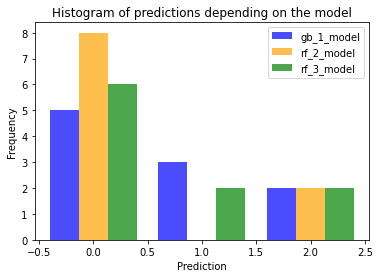

In [ ]:
plt.hist([gb_1_predictions, rf_2_predictions, rf_3_predictions], 
        bins=[-0.5, 0.5, 1.5, 2.5], alpha=0.7, color=['blue', 'orange', 'green'])

plt.xlabel('Prediction')
plt.ylabel('Frequency')
plt.title('Histogram of predictions depending on the model')
plt.legend(['gb_1_model', 'rf_2_model', 'rf_3_model'])

plt.show()

We can see that rf_2 model never predicts a tie and predicts a win when it's a tie, as we saw in the confusion matrix. The others make some predictions at ties, and all three predict equally a number of loses. Looking at the confusion matrix, we can see that when they predict a loose, the distribution between failing this prediction or not depending on the true results have the same distribution, as they must predict a loose for approximately the same matches.

At least, when we analyzed historical data, we saw that around the 50% of the time, the local team won (0), and when it got a tie or loose, was for both around 25% (1, 2). Taking this into account, it seems that both models gb_1 and rf_3 has this distribution of predictions, while rf_2 predicts the portion of ties as win.

Let's try to create a VotingClassifier with these 3 models. Despite of the fact that rf_2 doesn't predict a tie, it has anyway a really good prediction rate, and with the voting system, these ties that are really ties can be obtained when both models gb_1 and rf_3 predict a tie.

VOTING CLASSIFIER

We will try voting='hard' because we will take the result that is most predicted. We don't use weights, at least for now, because we want all models to have the same importance.

In [22]:
voting_model_1 = VotingClassifier(estimators=[('gb', gb_model_1),
                                                ('rf1', rf_model_2),
                                                ('rf2', rf_model_3)],
                                                voting='hard')
voting_model_1.fit(X_train, y_train)
voting_model_1_y_pred = voting_model_1.predict(X_test)
print(f"RMSE: {mean_squared_error(y_test, voting_model_1_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, voting_model_1_y_pred)}")
print(f"R^2: {r2_score(y_test, voting_model_1_y_pred)}")

RMSE: 1.1097708992990925
MAPE: 288829429783856.44
R^2: -0.7942107353168573


It takes a while to train the model, but this time required is insignificant. The R^2 seems quite good, but remember we are testing with matches that are in our data. The difficult ones to predict are the new results.
Let's see

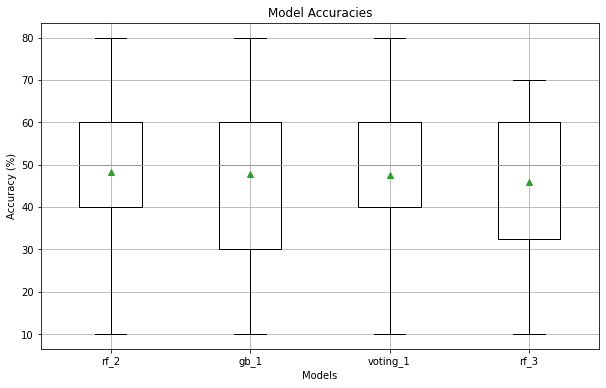

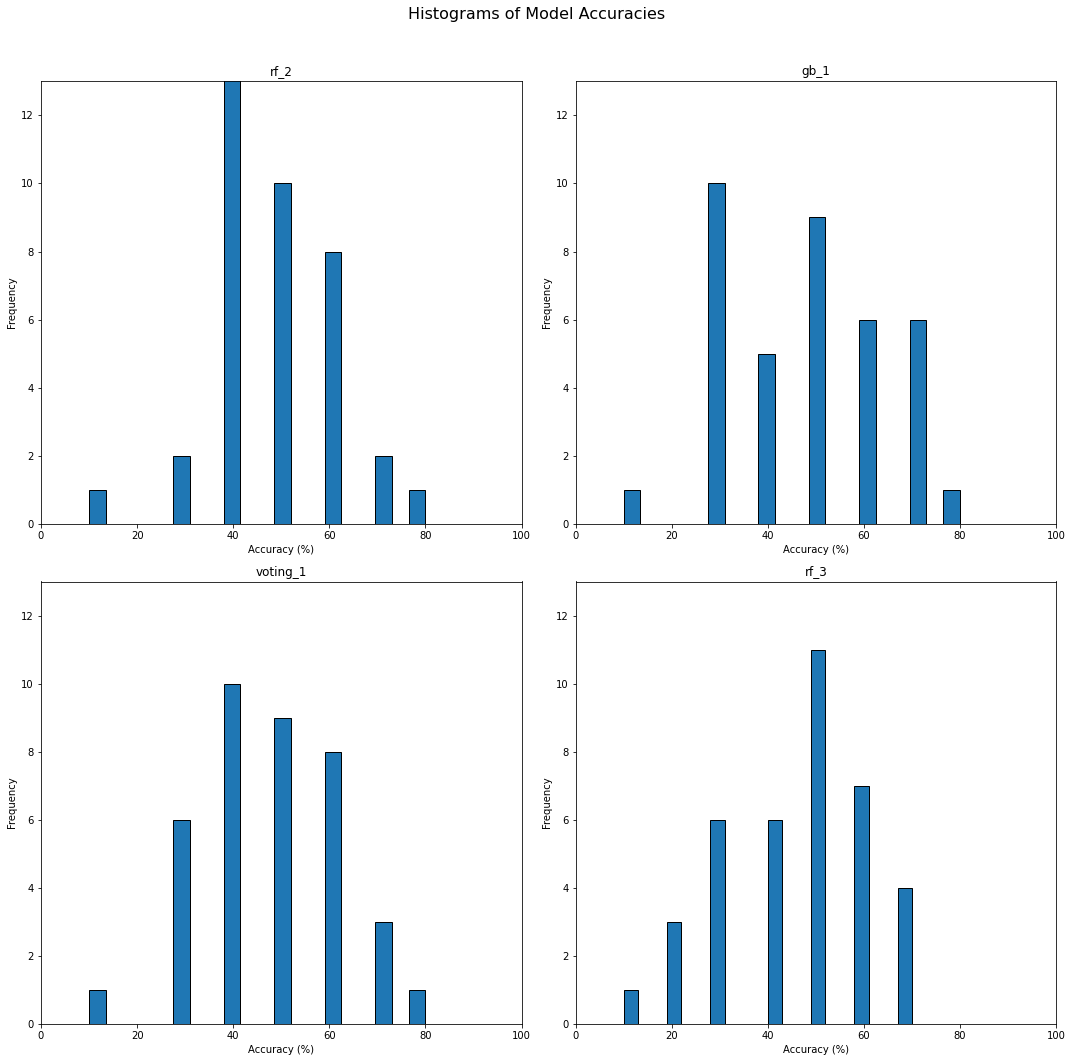

In [23]:
voting_1_accuracies = []
gb_1_accuracies = []
rf_2_accuracies = []
rf_3_accuracies = []
voting_1_total_predictions = []
gb_1_total_predictions = []
rf_2_total_predictions = []
rf_3_total_predictions = []
total_y_results = []

div = 1
matchdays_1 = [i + 1 for i in range(38)]
for matchday in matchdays_1:
    matchday_predict = dataset_predict_1.loc[(dataset_predict_1['division'] == div) & (dataset_predict_1['matchday'] == matchday)]
    X_predict, y_predict = matchday_predict[features], matchday_predict[target]
    voting_1_y_pred = voting_model_1.predict(X_predict)
    gb_1_y_pred = gb_model_1.predict(X_predict)
    rf_2_y_pred = rf_model_2.predict(X_predict)
    rf_3_y_pred = rf_model_3.predict(X_predict)
    
    real_results = y_predict.to_list()
    voting_1_predictions = voting_1_y_pred.tolist()
    gb_1_predictions = gb_1_y_pred.tolist()
    rf_2_predictions = rf_2_y_pred.tolist()
    rf_3_predictions = rf_3_y_pred.tolist()
    total_y_results += real_results
    voting_1_total_predictions += voting_1_predictions
    gb_1_total_predictions += gb_1_predictions
    rf_2_total_predictions += rf_2_predictions
    rf_3_total_predictions += rf_3_predictions
    
    total_matches = len(real_results)
    voting_1_total_predicted = 0
    gb_1_total_predicted = 0
    rf_2_total_predicted = 0
    rf_3_total_predicted = 0
    
    for i in range(total_matches):
        if real_results[i] == voting_1_predictions[i]:
            voting_1_total_predicted += 1
        if real_results[i] == gb_1_predictions[i]:
            gb_1_total_predicted += 1
        if real_results[i] == rf_2_predictions[i]:
            rf_2_total_predicted += 1
        if real_results[i] == rf_3_predictions[i]:
            rf_3_total_predicted += 1
    
    voting_1_accuracies.append(voting_1_total_predicted * 100 / total_matches)
    gb_1_accuracies.append(gb_1_total_predicted * 100 / total_matches)
    rf_2_accuracies.append(rf_2_total_predicted * 100 / total_matches)
    rf_3_accuracies.append(rf_3_total_predicted * 100 / total_matches)

models = ['voting_1', 'gb_1', 'rf_2', 'rf_3']
accuracies = [voting_1_accuracies, gb_1_accuracies,
            rf_2_accuracies, rf_3_accuracies]

mean_accuracies = [mean(acc) for acc in accuracies]

sorted_indices = sorted(range(len(mean_accuracies)), key=lambda k: mean_accuracies[k], reverse=True)
sorted_models = [models[i] for i in sorted_indices]
sorted_accuracies = [accuracies[i] for i in sorted_indices]

# Create a box plot
plt.figure(figsize=(10, 6))
plt.boxplot(sorted_accuracies, labels=sorted_models, showmeans=True)
plt.title('Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.grid(True)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.suptitle('Histograms of Model Accuracies', fontsize=16)

for i in range(2):
    for j in range(2):
        model_index = i * 2 + j
        axes[i, j].hist(sorted_accuracies[model_index], bins=20, edgecolor='black')
        axes[i, j].set_title(sorted_models[model_index])
        axes[i, j].set_xlabel('Accuracy (%)')
        axes[i, j].set_ylabel('Frequency')
        axes[i, j].set_xlim(0, 100)
        axes[i, j].set_ylim(0, 13)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])


plt.show()
    
    

It doesn't seem this voting model is better than the rest of the models. We can see that the accuracy doesn't increase compared to the others separately, and, in fact, has in general worse predictions than the gb_1 model. 
Let's see the confusion matrix, maybe it shows important information.

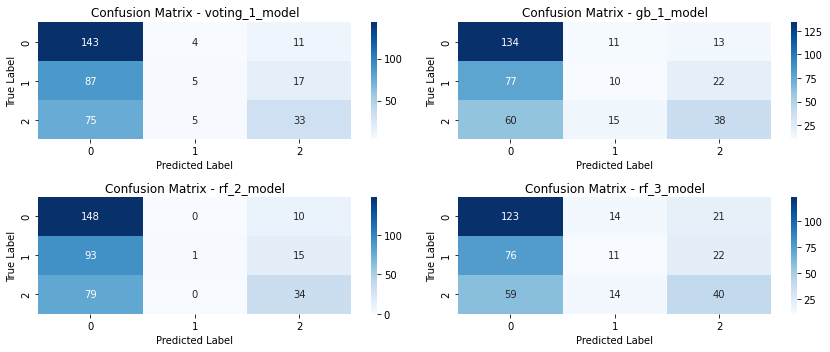

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

voting_1_cm = confusion_matrix(total_y_results, voting_1_total_predictions)
gb_1_cm = confusion_matrix(total_y_results, gb_1_total_predictions)
rf_2_cm = confusion_matrix(total_y_results, rf_2_total_predictions)
rf_3_cm = confusion_matrix(total_y_results, rf_3_total_predictions)

fig, axes = plt.subplots(2, 2, figsize=(12, 5))

# Confusion Matrix for voting_model_1
sns.heatmap(voting_1_cm, annot=True, fmt="d", cmap="Blues", ax=axes[0, 0])
axes[0, 0].set_title('Confusion Matrix - voting_1_model')
axes[0, 0].set_xlabel('Predicted Label')
axes[0, 0].set_ylabel('True Label')

# Confusion Matrix for gb_model_1
sns.heatmap(gb_1_cm, annot=True, fmt="d", cmap="Blues", ax=axes[0, 1])
axes[0, 1].set_title('Confusion Matrix - gb_1_model')
axes[0, 1].set_xlabel('Predicted Label')
axes[0, 1].set_ylabel('True Label')

# Confusion Matrix for rf_model_2
sns.heatmap(rf_2_cm, annot=True, fmt="d", cmap="Blues", ax=axes[1, 0])
axes[1, 0].set_title('Confusion Matrix - rf_2_model')
axes[1, 0].set_xlabel('Predicted Label')
axes[1, 0].set_ylabel('True Label')

# Confusion Matrix for rf_model_3
sns.heatmap(rf_3_cm, annot=True, fmt="d", cmap="Blues", ax=axes[1, 1])
axes[1, 1].set_title('Confusion Matrix - rf_3_model')
axes[1, 1].set_xlabel('Predicted Label')
axes[1, 1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

We can see that the voting_1 model tends to predict with the same distribution as the rf_3 model. We can notice that it tends to fail the most the ties. The influence fo the rf_2 maybe needs to be reduces in order to solve this problem. Look at the histogram of predictions

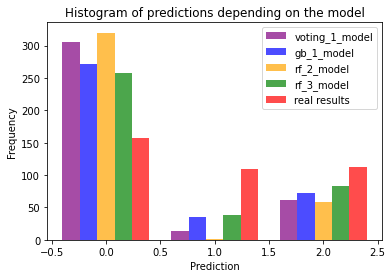

In [25]:
plt.hist([voting_1_total_predictions, gb_1_total_predictions,
        rf_2_total_predictions, rf_3_total_predictions, total_y_results], 
        bins=[-0.5, 0.5, 1.5, 2.5], alpha=0.7, color=['purple', 'blue', 'orange', 'green', 'red'])

plt.xlabel('Prediction')
plt.ylabel('Frequency')
plt.title('Histogram of predictions depending on the model')
plt.legend(['voting_1_model', 'gb_1_model', 'rf_2_model', 'rf_3_model', 'real results'])

plt.show()

We see that, even though it tries to predict some ties, the increase of the wins predicted compared to the usually 50% when playing local may be due to this lack of ties predictions. 
Let's try a voting model that gives more importance to the gb_1 and rf_3 models, so maybe their tries at predicting ties get more influence. In this case, it is better to use a soft voting, as the one predcited is which has the highest summed probability, weighted by the individual classifier's weight. 

In [31]:
voting_model_2 = VotingClassifier(estimators=[('gb', gb_model_1),
                                                ('rf1', rf_model_2),
                                                ('rf2', rf_model_3)],
                                voting='soft',
                                weights=[2, 1, 2])
voting_model_2.fit(X_train, y_train)
voting_model_2_y_pred = voting_model_2.predict(X_test)
print(f"RMSE: {mean_squared_error(y_test, voting_model_2_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, voting_model_2_y_pred)}")
print(f"R^2: {r2_score(y_test, voting_model_2_y_pred)}")

RMSE: 1.1003670301086446
MAPE: 393128946094693.3
R^2: -0.7639323477874023


At first view, it has a worst R^2, but let's see if it works better predicting results out of the training set.

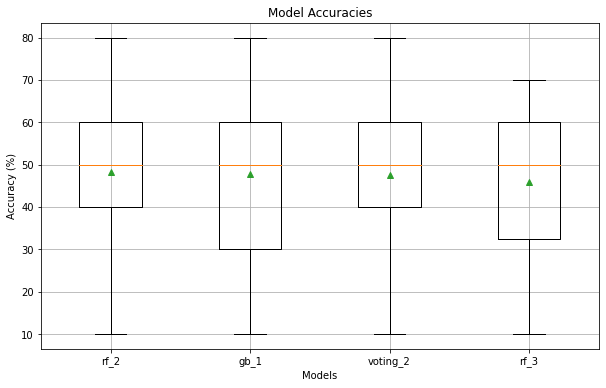

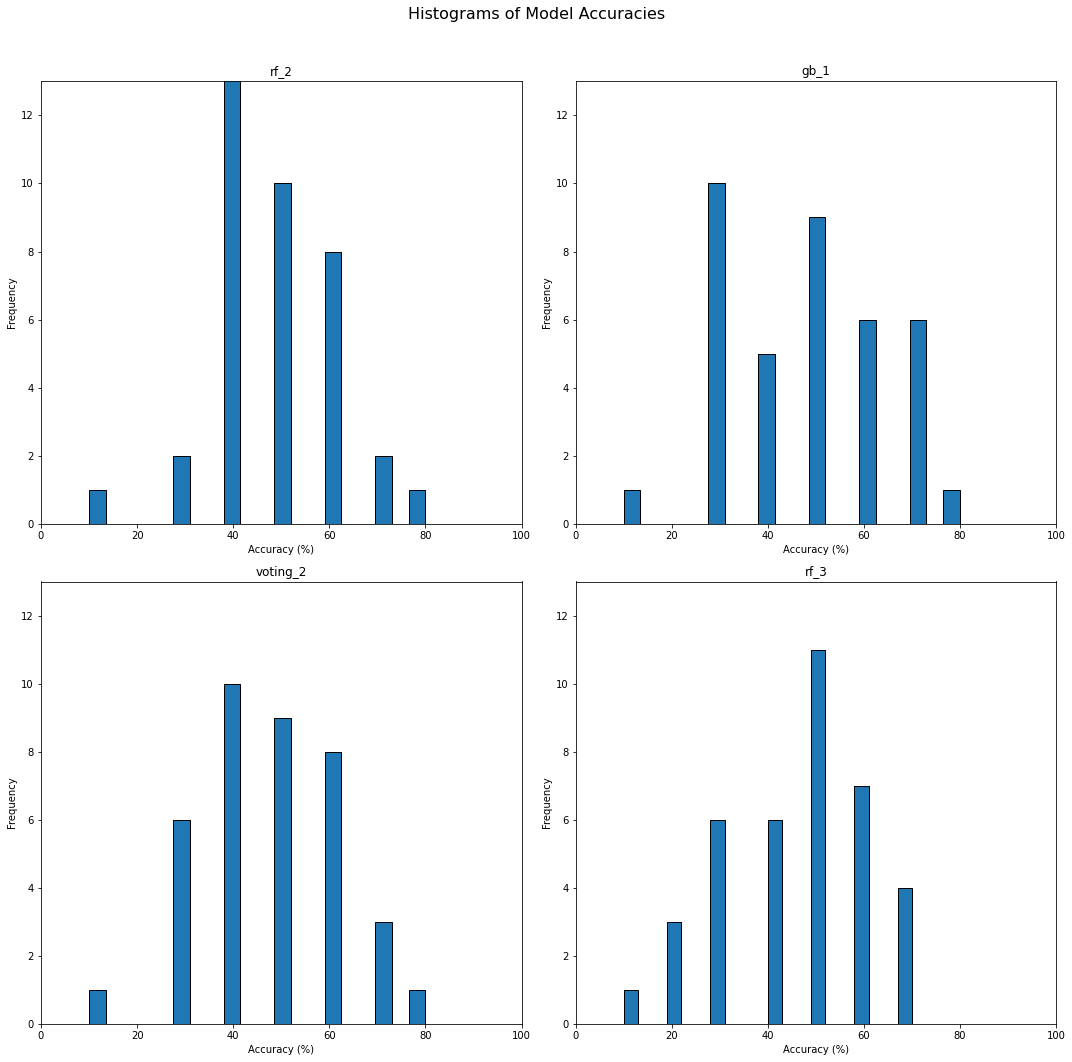

In [32]:
voting_2_accuracies = []
gb_1_accuracies = []
rf_2_accuracies = []
rf_3_accuracies = []
voting_2_total_predictions = []
gb_1_total_predictions = []
rf_2_total_predictions = []
rf_3_total_predictions = []
total_y_results = []

div = 1
matchdays_1 = [i + 1 for i in range(38)]
for matchday in matchdays_1:
    matchday_predict = dataset_predict_1.loc[(dataset_predict_1['division'] == div) & (dataset_predict_1['matchday'] == matchday)]
    X_predict, y_predict = matchday_predict[features], matchday_predict[target]
    voting_2_y_pred = voting_model_1.predict(X_predict)
    gb_1_y_pred = gb_model_1.predict(X_predict)
    rf_2_y_pred = rf_model_2.predict(X_predict)
    rf_3_y_pred = rf_model_3.predict(X_predict)
    
    real_results = y_predict.to_list()
    voting_3_predictions = voting_2_y_pred.tolist()
    gb_1_predictions = gb_1_y_pred.tolist()
    rf_2_predictions = rf_2_y_pred.tolist()
    rf_3_predictions = rf_3_y_pred.tolist()
    total_y_results += real_results
    voting_2_total_predictions += voting_2_predictions
    gb_1_total_predictions += gb_1_predictions
    rf_2_total_predictions += rf_2_predictions
    rf_3_total_predictions += rf_3_predictions
    
    total_matches = len(real_results)
    voting_2_total_predicted = 0
    gb_1_total_predicted = 0
    rf_2_total_predicted = 0
    rf_3_total_predicted = 0
    
    for i in range(total_matches):
        if real_results[i] == voting_2_predictions[i]:
            voting_2_total_predicted += 1
        if real_results[i] == gb_1_predictions[i]:
            gb_1_total_predicted += 1
        if real_results[i] == rf_2_predictions[i]:
            rf_2_total_predicted += 1
        if real_results[i] == rf_3_predictions[i]:
            rf_3_total_predicted += 1
    
    voting_2_accuracies.append(voting_2_total_predicted * 100 / total_matches)
    gb_1_accuracies.append(gb_1_total_predicted * 100 / total_matches)
    rf_2_accuracies.append(rf_2_total_predicted * 100 / total_matches)
    rf_3_accuracies.append(rf_3_total_predicted * 100 / total_matches)

models = ['voting_2', 'gb_1', 'rf_2', 'rf_3']
accuracies = [voting_2_accuracies, gb_1_accuracies,
            rf_2_accuracies, rf_3_accuracies]

mean_accuracies = [mean(acc) for acc in accuracies]

sorted_indices = sorted(range(len(mean_accuracies)), key=lambda k: mean_accuracies[k], reverse=True)
sorted_models = [models[i] for i in sorted_indices]
sorted_accuracies = [accuracies[i] for i in sorted_indices]

# Create a box plot
plt.figure(figsize=(10, 6))
plt.boxplot(sorted_accuracies, labels=sorted_models, showmeans=True)
plt.title('Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.grid(True)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.suptitle('Histograms of Model Accuracies', fontsize=16)

for i in range(2):
    for j in range(2):
        model_index = i * 2 + j
        axes[i, j].hist(sorted_accuracies[model_index], bins=20, edgecolor='black')
        axes[i, j].set_title(sorted_models[model_index])
        axes[i, j].set_xlabel('Accuracy (%)')
        axes[i, j].set_ylabel('Frequency')
        axes[i, j].set_xlim(0, 100)
        axes[i, j].set_ylim(0, 13)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])


plt.show()
    
    

The accuracy of voting_2 model in less distributed than voting_1, and the majority of the matchdays has between 30 and 50% of accueracy, so it's not better than the voting_1 model.

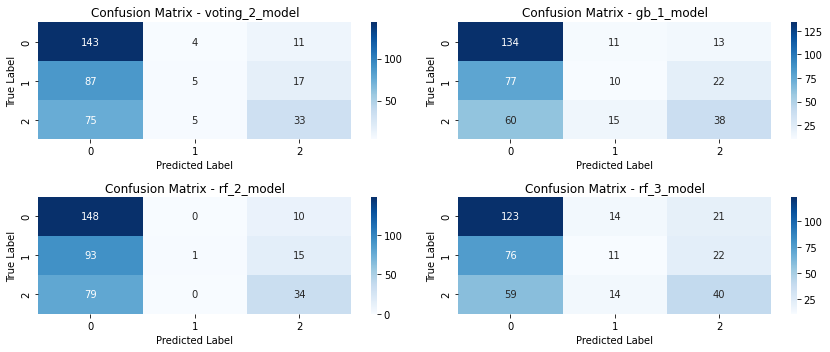

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

voting_2_cm = confusion_matrix(total_y_results, voting_2_total_predictions)
gb_1_cm = confusion_matrix(total_y_results, gb_1_total_predictions)
rf_2_cm = confusion_matrix(total_y_results, rf_2_total_predictions)
rf_3_cm = confusion_matrix(total_y_results, rf_3_total_predictions)

fig, axes = plt.subplots(2, 2, figsize=(12, 5))

# Confusion Matrix for voting_model_1
sns.heatmap(voting_2_cm, annot=True, fmt="d", cmap="Blues", ax=axes[0, 0])
axes[0, 0].set_title('Confusion Matrix - voting_2_model')
axes[0, 0].set_xlabel('Predicted Label')
axes[0, 0].set_ylabel('True Label')

# Confusion Matrix for gb_model_1
sns.heatmap(gb_1_cm, annot=True, fmt="d", cmap="Blues", ax=axes[0, 1])
axes[0, 1].set_title('Confusion Matrix - gb_1_model')
axes[0, 1].set_xlabel('Predicted Label')
axes[0, 1].set_ylabel('True Label')

# Confusion Matrix for rf_model_2
sns.heatmap(rf_2_cm, annot=True, fmt="d", cmap="Blues", ax=axes[1, 0])
axes[1, 0].set_title('Confusion Matrix - rf_2_model')
axes[1, 0].set_xlabel('Predicted Label')
axes[1, 0].set_ylabel('True Label')

# Confusion Matrix for rf_model_3
sns.heatmap(rf_3_cm, annot=True, fmt="d", cmap="Blues", ax=axes[1, 1])
axes[1, 1].set_title('Confusion Matrix - rf_3_model')
axes[1, 1].set_xlabel('Predicted Label')
axes[1, 1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

Regarding the confusion matrix, we see that it's almost the same as for the voting_1 model. The only difference is that it seems to predict some of the "ties" for the voting_1 model as 0, when the true value is 2, so it doesn't help at all.

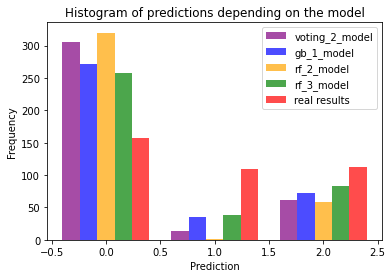

In [30]:
plt.hist([voting_2_total_predictions, gb_1_total_predictions,
        rf_2_total_predictions, rf_3_total_predictions, total_y_results], 
        bins=[-0.5, 0.5, 1.5, 2.5], alpha=0.7, color=['purple', 'blue', 'orange', 'green', 'red'])

plt.xlabel('Prediction')
plt.ylabel('Frequency')
plt.title('Histogram of predictions depending on the model')
plt.legend(['voting_2_model', 'gb_1_model', 'rf_2_model', 'rf_3_model', 'real results'])

plt.show()

This histogram is exactly the same as before, so it doesn't seem to add extra information about the model.

To sum up, it seems that this second version of the voting model is not much better than the first one (we have tried with different distributions). Let's see if we try a model where the gb_1 has more importance, as it seems to be better than the others.

In [35]:
voting_model_3 = VotingClassifier(estimators=[('gb', gb_model_1),
                                                ('rf1', rf_model_2),
                                                ('rf2', rf_model_3)],
                                voting='soft',
                                weights=[1, 3, 1])
voting_model_3.fit(X_train, y_train)
voting_model_3_y_pred = voting_model_3.predict(X_test)
print(f"RMSE: {mean_squared_error(y_test, voting_model_3_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, voting_model_3_y_pred)}")
print(f"R^2: {r2_score(y_test, voting_model_3_y_pred)}")

RMSE: 1.1111078120827245
MAPE: 262085964063129.03
R^2: -0.7985362192496366


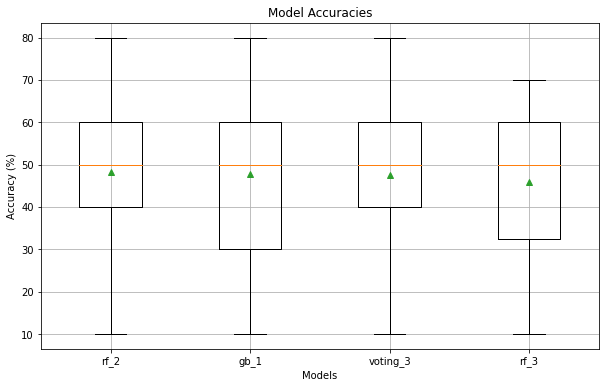

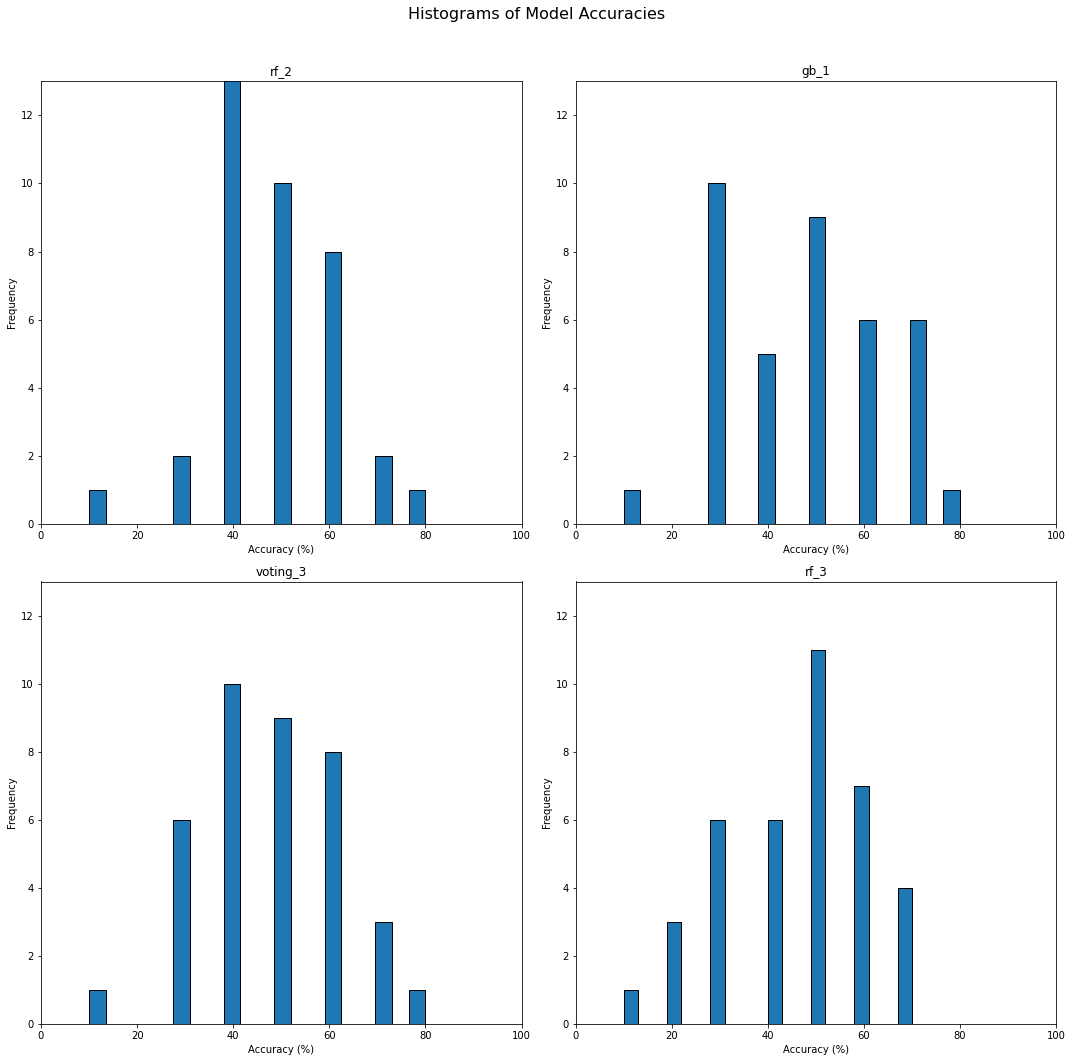

In [37]:
voting_3_accuracies = []
gb_1_accuracies = []
rf_2_accuracies = []
rf_3_accuracies = []
voting_3_total_predictions = []
gb_1_total_predictions = []
rf_2_total_predictions = []
rf_3_total_predictions = []
total_y_results = []

div = 1
matchdays_1 = [i + 1 for i in range(38)]
for matchday in matchdays_1:
    matchday_predict = dataset_predict_1.loc[(dataset_predict_1['division'] == div) & (dataset_predict_1['matchday'] == matchday)]
    X_predict, y_predict = matchday_predict[features], matchday_predict[target]
    voting_3_y_pred = voting_model_1.predict(X_predict)
    gb_1_y_pred = gb_model_1.predict(X_predict)
    rf_2_y_pred = rf_model_2.predict(X_predict)
    rf_3_y_pred = rf_model_3.predict(X_predict)
    
    real_results = y_predict.to_list()
    voting_3_predictions = voting_3_y_pred.tolist()
    gb_1_predictions = gb_1_y_pred.tolist()
    rf_2_predictions = rf_2_y_pred.tolist()
    rf_3_predictions = rf_3_y_pred.tolist()
    total_y_results += real_results
    voting_3_total_predictions += voting_3_predictions
    gb_1_total_predictions += gb_1_predictions
    rf_2_total_predictions += rf_2_predictions
    rf_3_total_predictions += rf_3_predictions
    
    total_matches = len(real_results)
    voting_3_total_predicted = 0
    gb_1_total_predicted = 0
    rf_2_total_predicted = 0
    rf_3_total_predicted = 0
    
    for i in range(total_matches):
        if real_results[i] == voting_3_predictions[i]:
            voting_3_total_predicted += 1
        if real_results[i] == gb_1_predictions[i]:
            gb_1_total_predicted += 1
        if real_results[i] == rf_2_predictions[i]:
            rf_2_total_predicted += 1
        if real_results[i] == rf_3_predictions[i]:
            rf_3_total_predicted += 1
    
    voting_3_accuracies.append(voting_3_total_predicted * 100 / total_matches)
    gb_1_accuracies.append(gb_1_total_predicted * 100 / total_matches)
    rf_2_accuracies.append(rf_2_total_predicted * 100 / total_matches)
    rf_3_accuracies.append(rf_3_total_predicted * 100 / total_matches)

models = ['voting_3', 'gb_1', 'rf_2', 'rf_3']
accuracies = [voting_3_accuracies, gb_1_accuracies,
            rf_2_accuracies, rf_3_accuracies]

mean_accuracies = [mean(acc) for acc in accuracies]

sorted_indices = sorted(range(len(mean_accuracies)), key=lambda k: mean_accuracies[k], reverse=True)
sorted_models = [models[i] for i in sorted_indices]
sorted_accuracies = [accuracies[i] for i in sorted_indices]

# Create a box plot
plt.figure(figsize=(10, 6))
plt.boxplot(sorted_accuracies, labels=sorted_models, showmeans=True)
plt.title('Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.grid(True)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.suptitle('Histograms of Model Accuracies', fontsize=16)

for i in range(2):
    for j in range(2):
        model_index = i * 2 + j
        axes[i, j].hist(sorted_accuracies[model_index], bins=20, edgecolor='black')
        axes[i, j].set_title(sorted_models[model_index])
        axes[i, j].set_xlabel('Accuracy (%)')
        axes[i, j].set_ylabel('Frequency')
        axes[i, j].set_xlim(0, 100)
        axes[i, j].set_ylim(0, 13)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])


plt.show()
    
    

Well, it really seems that this model is better if we want more consistency in the accuracy, which means that generally the accuracy is more than 40%. The mean is aproximately the same, but with less variance and doesn't expect so many accuracies under 40%.

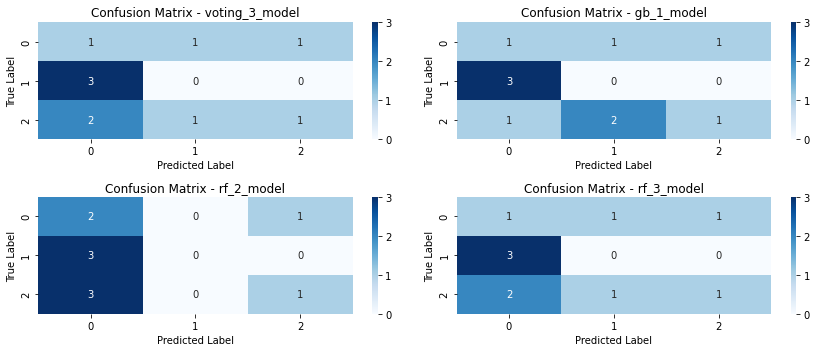

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

voting_3_cm = confusion_matrix(y_predict, voting_3_predictions)
gb_1_cm = confusion_matrix(y_predict, gb_1_predictions)
rf_2_cm = confusion_matrix(y_predict, rf_2_predictions)
rf_3_cm = confusion_matrix(y_predict, rf_3_predictions)

fig, axes = plt.subplots(2, 2, figsize=(12, 5))

# Confusion Matrix for voting_model_1
sns.heatmap(voting_3_cm, annot=True, fmt="d", cmap="Blues", ax=axes[0, 0])
axes[0, 0].set_title('Confusion Matrix - voting_3_model')
axes[0, 0].set_xlabel('Predicted Label')
axes[0, 0].set_ylabel('True Label')

# Confusion Matrix for gb_model_1
sns.heatmap(gb_1_cm, annot=True, fmt="d", cmap="Blues", ax=axes[0, 1])
axes[0, 1].set_title('Confusion Matrix - gb_1_model')
axes[0, 1].set_xlabel('Predicted Label')
axes[0, 1].set_ylabel('True Label')

# Confusion Matrix for rf_model_2
sns.heatmap(rf_2_cm, annot=True, fmt="d", cmap="Blues", ax=axes[1, 0])
axes[1, 0].set_title('Confusion Matrix - rf_2_model')
axes[1, 0].set_xlabel('Predicted Label')
axes[1, 0].set_ylabel('True Label')

# Confusion Matrix for rf_model_3
sns.heatmap(rf_3_cm, annot=True, fmt="d", cmap="Blues", ax=axes[1, 1])
axes[1, 1].set_title('Confusion Matrix - rf_3_model')
axes[1, 1].set_xlabel('Predicted Label')
axes[1, 1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

Regarding the confusion matrix, we can actually say the same as for the voting_2 model. 

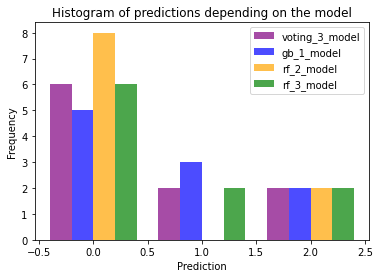

In [ ]:
plt.hist([voting_3_predictions, gb_1_predictions, rf_2_predictions, rf_3_predictions], 
        bins=[-0.5, 0.5, 1.5, 2.5], alpha=0.7, color=['purple', 'blue', 'orange', 'green'])

plt.xlabel('Prediction')
plt.ylabel('Frequency')
plt.title('Histogram of predictions depending on the model')
plt.legend(['voting_3_model', 'gb_1_model', 'rf_2_model', 'rf_3_model'])

plt.show()

The same for the histogram of predictions.

In conclusion, it seems that the first voting model is quite good.

What has surprised us is that the prediction capacity doesn't seem much good enough. Bearing in mind that almost the 50% of the matches are won by the local (at least analyzing the whole historical data), a 50% accuracy seem bad, as chosing always win will give you the same accuracy.

Let's see if this is true for the last 10 seasons. However, we are not saying the model is bad at all. What we are saying is an objective observation that surprise us. It's true that surely our model predicts the results "phillosophically" better, as the decision is made depending on historical data and "thinking" what could come next.

Imagine a model win_model that always predict 0:

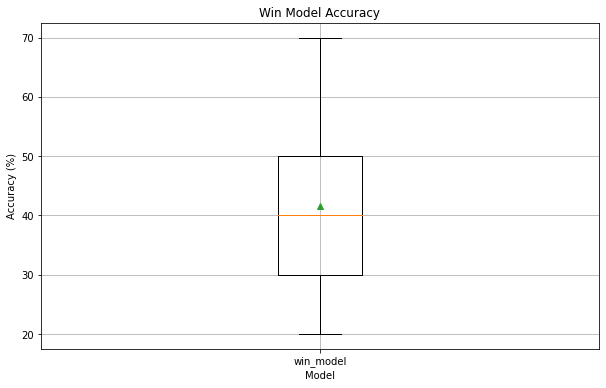

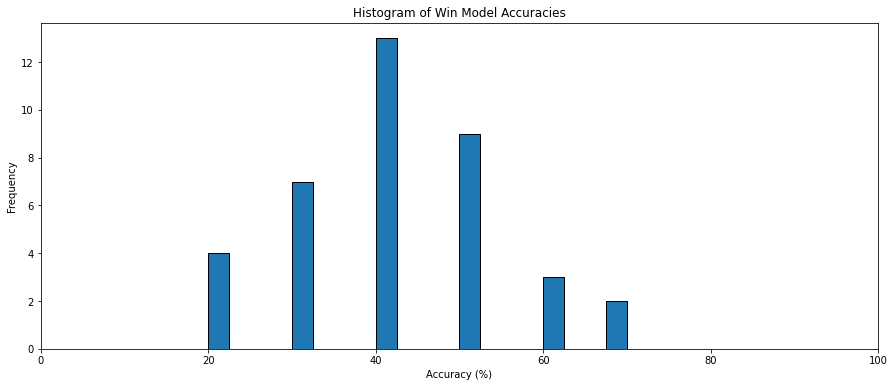

In [ ]:
win_accuracies = []
div = 1
matchdays_1 = [i + 1 for i in range(38)]
for matchday in matchdays_1:
    matchday_predict = dataset_predict_1.loc[(dataset_predict_1['division'] == div) & (dataset_predict_1['matchday'] == matchday)]
    X_predict, y_predict = matchday_predict[features], matchday_predict[target]
    
    real_results = y_predict.to_list()
    
    total_matches = len(real_results)
    win_total_predicted = 0
    
    for i in range(total_matches):
        if real_results[i] == 0:
            win_total_predicted += 1
    
    win_accuracies.append(win_total_predicted * 100 / total_matches)
    
# Box plot
plt.figure(figsize=(10, 6))
plt.boxplot(win_accuracies, labels=['win_model'], showmeans=True)
plt.title('Win Model Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.grid(True)

# Histogram
plt.figure(figsize=(15, 6))
plt.hist(win_accuracies, bins=20, edgecolor='black')
plt.title('Histogram of Win Model Accuracies')
plt.xlabel('Accuracy (%)')
plt.ylabel('Frequency')
plt.xlim(0, 100)

plt.show()

Well, it has "good" predictions, as the distribution of accuracy is more or less the same as for real models. However, this experiment was just used to show our observations and won't have any effect in our decided model.

TRAINING THE MODEL WITH ALL THE DATA FOR THE EXERCISE AND PREDICT THE LAST SEASON RESULTS

In [38]:


def preparing_training_dataset_2():
    data = io.load_historical_data(("2010-2011", "2011-2012", "2012-2013", "2013-2014", "2014-2015", "2015-2016", "2016-2017", "2017-2018", "2018-2019", "2019-2020", "2020-2021"))
    data[['local_goals', 'visitor_goals']] = data['score'].str.split(':', expand=True).astype(float)
    data['winner'] = data.apply(determine_winner, axis=1)
    data['goal_difference'] = data['local_goals'] - data['visitor_goals']
    data['weekday'] = data['date'].apply(weekday_match)
    
    home_team_df = data.copy()
    home_team_df['team'], home_team_df['rival'], home_team_df['condition'] = home_team_df['home_team'], home_team_df['away_team'], 'local'
    away_team_df = data.copy()
    away_team_df['team'], away_team_df['rival'], away_team_df['condition']= away_team_df['away_team'], away_team_df['home_team'], 'visitor'
    
    matches_data = pd.concat([home_team_df, away_team_df], ignore_index=True).sort_values(by=['season', 'division', 'team', 'matchday'])
    matches_data.reset_index(drop=True, inplace=True)
    
    matches_data['GF_match'] = matches_data.apply(lambda row: row['local_goals'] if row['condition'] == 'local' else row['visitor_goals'], axis=1)
    matches_data['GA_match'] = matches_data.apply(lambda row: row['visitor_goals'] if row['condition'] == 'local' else row['local_goals'], axis=1)
    matches_data['GD_match'] = matches_data['GF_match'] - matches_data['GA_match']
    matches_data['W_match'] = ((matches_data['winner'] == 'Local') & (matches_data['condition'] == 'local')) | ((matches_data['winner'] == 'Visitor') & (matches_data['condition'] == 'visitor'))
    matches_data['L_match'] = ((matches_data['winner'] == 'Visitor') & (matches_data['condition'] == 'local')) | ((matches_data['winner'] == 'Local') & (matches_data['condition'] == 'visitor'))
    matches_data['T_match'] = (matches_data['winner'] == 'Tie')
    matches_data['match_result'] = matches_data.apply(match_result, axis=1)
    matches_data['last_match_result_1'] = matches_data.groupby(['season', 'team'])['match_result'].shift(1)
    matches_data['last_match_result_2'] = matches_data.groupby(['season', 'team'])['match_result'].shift(2)
    matches_data['last_match_result_3'] = matches_data.groupby(['season', 'team'])['match_result'].shift(3)
    matches_data['last_match_result_4'] = matches_data.groupby(['season', 'team'])['match_result'].shift(4)
    matches_data['last_match_result_5'] = matches_data.groupby(['season', 'team'])['match_result'].shift(5)
    matches_data['last_5_results_local'] = matches_data[['last_match_result_1', 'last_match_result_2', 'last_match_result_3', 
                                                'last_match_result_4', 'last_match_result_5']].values.tolist()

    matches_data['GF'] = matches_data.groupby(['season', 'team'])['GF_match'].cumsum()
    matches_data['GA'] = matches_data.groupby(['season', 'team'])['GA_match'].cumsum()
    matches_data['W'] = matches_data.groupby(['season', 'team'])['W_match'].cumsum()
    matches_data['L'] = matches_data.groupby(['season', 'team'])['L_match'].cumsum()
    matches_data['T'] = matches_data.groupby(['season', 'team'])['T_match'].cumsum()
    
    final_ranking = matches_data.reset_index()
    final_ranking['GD'] = final_ranking['GF'] - final_ranking['GA']
    final_ranking['Pts'] = final_ranking['W'] * 3 + final_ranking['T']
    final_ranking = final_ranking.sort_values(by=['season', 'division', 'matchday', 'Pts', 'GD'], ascending=[False, True, True, False, False])
    final_ranking.reset_index(drop=True, inplace=True)
    final_ranking['rank'] = final_ranking.groupby(['season', 'division', 'matchday'])['Pts'].rank(ascending=False, method='first').astype(int)
    
    final_ranking = final_ranking[['season', 'division', 'matchday', 'weekday', 'time', 'rank', 'team', 'rival', 'condition', 'winner', 'GF_match', 'GA_match', 'GD_match', 'GF', 'GA', 'GD', 'W', 'L', 'T', 'Pts', 'last_5_results_local']]
    ### Prepare numerical data
    #season
    seasons_string = final_ranking['season'].unique()
    seasons_list = list(reversed(range(2010, 2021)))
    final_ranking['season'] = final_ranking['season'].replace(seasons_string, seasons_list)
    #time
    final_ranking['time'] = final_ranking['time'].apply(numerical_time)
    #team / rival
    team_names, team_ids = encoder_teams()
    final_ranking[['team', 'rival']] = final_ranking[['team', 'rival']].replace(team_names, team_ids)
    
    #winner --> 0: Local, 1: Tie, 2:Visitor
    final_ranking['winner'] = final_ranking['winner'].replace(['Local', 'Tie', 'Visitor'], [0, 1, 2])
    #last 5 results
    final_ranking['last_5_results_local'] = final_ranking['last_5_results_local'].apply(numerical_last_results_local)
    mapping = final_ranking.groupby(['season', 'matchday']).apply(lambda x: dict(zip(x['team'], x['last_5_results_local']))).to_dict()
    final_ranking['last_5_results_rival'] = final_ranking.apply(lambda row: mapping.get((row['season'], row['matchday']), {}).get(row['rival'], None), axis=1)
    # The matches are repeated: Drop when condition is Visitor
    final_ranking = final_ranking.loc[final_ranking['condition'] == 'local']

    final_ranking.to_excel('./analysis/training_dataset_2.xlsx')
    return final_ranking


# Aux function
def weekday_match(date):
    month, day, year = map(int, date.split('/'))
    year += 2000
    
    n_weekday = datetime.date(year, month, day).weekday()
    return n_weekday

def determine_winner(row):
    if row['local_goals'] > row['visitor_goals']:
        return 'Local'
    elif row['local_goals'] < row['visitor_goals']:
        return 'Visitor'
    else:
        return 'Tie'
    
def match_result(row):
    if row['W_match'] == True:
        return 'W'
    elif row['L_match'] == True:
        return 'L'
    elif row['T_match'] == True:
        return 'T'
    
def numerical_time(time_string):
    if time_string is None:
        time_string = "12:00 AM"
    time_parts = datetime.datetime.strptime(time_string, "%I:%M %p")
    time_num = time_parts.hour + time_parts.minute / 60
    return time_num

def numerical_last_results_local(last_results_list):
    total = 0
    for result in last_results_list:
        if result == 'W':
            total += 3
        elif result == 'T':
            total += 1
        else:
            total += -3
    return total

dataset_2 = preparing_training_dataset_2()
print(dataset_2)

       season  division  matchday  weekday  time  rank  team  rival condition  \
0        2020         1         1        2  19.0     1    10     25     local   
1        2020         1         1        1  21.5     2     9     18     local   
3        2020         1         1        5  18.5     4    22     13     local   
4        2020         1         1        1  21.0     5    12     14     local   
5        2020         1         1        6  21.0     6    11      2     local   
...       ...       ...       ...      ...   ...   ...   ...    ...       ...   
18513    2010         2        42        5  20.0    12    41     22     local   
18516    2010         2        42        5  18.0    15    28     44     local   
18520    2010         2        42        5  18.0    19    35     43     local   
18522    2010         2        42        5  18.0    21    34     39     local   
18523    2010         2        42        5  18.0    22    36     32     local   

       winner  ...  GD_matc

In [39]:
features = ['season', 'division', 'matchday', 'weekday', 'time', 'team', 'rival', 'last_5_results_local','last_5_results_rival']
target = "winner"
X, y = dataset_2[features], dataset_2[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [40]:
gb_model_1 = GradientBoostingClassifier()
gb_model_1.fit(X_train, y_train)
gb_model_1_y_pred = gb_model_1.predict(X_test)
print(f"RMSE: {mean_squared_error(y_test, gb_model_1_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, gb_model_1_y_pred)}")
print(f"R^2: {r2_score(y_test, gb_model_1_y_pred)}")

RMSE: 1.10754659998029
MAPE: 418035151596182.44
R^2: -0.7938128567400831


In [41]:
rf_model_2 = RandomForestClassifier(n_estimators=200, max_depth=6, random_state=15)
rf_model_2.fit(X_train, y_train)
rf_model_2_y_pred = rf_model_2.predict(X_test)
print(f"RMSE: {mean_squared_error(y_test, rf_model_2_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, rf_model_2_y_pred)}")
print(f"R^2: {r2_score(y_test, rf_model_2_y_pred)}")

RMSE: 1.1201437730555683
MAPE: 189574080375013.2
R^2: -0.8348503704006567


In [42]:
rf_model_3 = RandomForestClassifier(n_estimators=300, max_depth=15, random_state=15)
rf_model_3.fit(X_train, y_train)
rf_model_3_y_pred = rf_model_3.predict(X_test)
print(f"RMSE: {mean_squared_error(y_test, rf_model_3_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, rf_model_3_y_pred)}")
print(f"R^2: {r2_score(y_test, rf_model_3_y_pred)}")

RMSE: 1.1099802364017004
MAPE: 668370155168314.6
R^2: -0.8017046862901933


In [43]:
def preparing__predicting_dataset_2():
    data = io.load_historical_data("all")
    data = data.loc[data['season'] == "2021-2022"]
    data[['local_goals', 'visitor_goals']] = data['score'].str.split(':', expand=True).astype(float)
    data['winner'] = data.apply(determine_winner, axis=1)
    data['goal_difference'] = data['local_goals'] - data['visitor_goals']
    data['weekday'] = data['date'].apply(weekday_match)
    
    home_team_df = data.copy()
    home_team_df['team'], home_team_df['rival'], home_team_df['condition'] = home_team_df['home_team'], home_team_df['away_team'], 'local'
    away_team_df = data.copy()
    away_team_df['team'], away_team_df['rival'], away_team_df['condition']= away_team_df['away_team'], away_team_df['home_team'], 'visitor'
    
    matches_data = pd.concat([home_team_df, away_team_df], ignore_index=True).sort_values(by=['season', 'division', 'team', 'matchday'])
    matches_data.reset_index(drop=True, inplace=True)
    
    matches_data['GF_match'] = matches_data.apply(lambda row: row['local_goals'] if row['condition'] == 'local' else row['visitor_goals'], axis=1)
    matches_data['GA_match'] = matches_data.apply(lambda row: row['visitor_goals'] if row['condition'] == 'local' else row['local_goals'], axis=1)
    matches_data['GD_match'] = matches_data['GF_match'] - matches_data['GA_match']
    matches_data['W_match'] = ((matches_data['winner'] == 'Local') & (matches_data['condition'] == 'local')) | ((matches_data['winner'] == 'Visitor') & (matches_data['condition'] == 'visitor'))
    matches_data['L_match'] = ((matches_data['winner'] == 'Visitor') & (matches_data['condition'] == 'local')) | ((matches_data['winner'] == 'Local') & (matches_data['condition'] == 'visitor'))
    matches_data['T_match'] = (matches_data['winner'] == 'Tie')
    matches_data['match_result'] = matches_data.apply(match_result, axis=1)
    matches_data['last_match_result_1'] = matches_data.groupby(['season', 'team'])['match_result'].shift(1)
    matches_data['last_match_result_2'] = matches_data.groupby(['season', 'team'])['match_result'].shift(2)
    matches_data['last_match_result_3'] = matches_data.groupby(['season', 'team'])['match_result'].shift(3)
    matches_data['last_match_result_4'] = matches_data.groupby(['season', 'team'])['match_result'].shift(4)
    matches_data['last_match_result_5'] = matches_data.groupby(['season', 'team'])['match_result'].shift(5)
    matches_data['last_5_results_local'] = matches_data[['last_match_result_1', 'last_match_result_2', 'last_match_result_3', 
                                                'last_match_result_4', 'last_match_result_5']].values.tolist()

    matches_data['GF'] = matches_data.groupby(['season', 'team'])['GF_match'].cumsum()
    matches_data['GA'] = matches_data.groupby(['season', 'team'])['GA_match'].cumsum()
    matches_data['W'] = matches_data.groupby(['season', 'team'])['W_match'].cumsum()
    matches_data['L'] = matches_data.groupby(['season', 'team'])['L_match'].cumsum()
    matches_data['T'] = matches_data.groupby(['season', 'team'])['T_match'].cumsum()
    
    final_ranking = matches_data.reset_index()
    final_ranking['GD'] = final_ranking['GF'] - final_ranking['GA']
    final_ranking['Pts'] = final_ranking['W'] * 3 + final_ranking['T']
    final_ranking = final_ranking.sort_values(by=['season', 'division', 'matchday', 'Pts', 'GD'], ascending=[False, True, True, False, False])
    final_ranking.reset_index(drop=True, inplace=True)
    final_ranking['rank'] = final_ranking.groupby(['season', 'division', 'matchday'])['Pts'].rank(ascending=False, method='first').astype(int)
    
    final_ranking = final_ranking[['season', 'division', 'matchday', 'weekday', 'time', 'rank', 'team', 'rival', 'condition', 'winner', 'GF_match', 'GA_match', 'GD_match', 'GF', 'GA', 'GD', 'W', 'L', 'T', 'Pts', 'last_5_results_local']]
    ### Prepare numerical data
    #season
    final_ranking['season'] = final_ranking['season'].replace("2021-2022", 2021)
    #time
    final_ranking['time'] = final_ranking['time'].apply(numerical_time)
    #team / rival
    team_names, team_ids = encoder_teams()
    final_ranking[['team', 'rival']] = final_ranking[['team', 'rival']].replace(team_names, team_ids)
    
    #winner --> 0: Local, 1: Tie, 2:Visitor
    final_ranking['winner'] = final_ranking['winner'].replace(['Local', 'Tie', 'Visitor'], [0, 1, 2])
    #last 5 results
    final_ranking['last_5_results_local'] = final_ranking['last_5_results_local'].apply(numerical_last_results_local)
    mapping = final_ranking.groupby(['season', 'matchday']).apply(lambda x: dict(zip(x['team'], x['last_5_results_local']))).to_dict()
    final_ranking['last_5_results_rival'] = final_ranking.apply(lambda row: mapping.get((row['season'], row['matchday']), {}).get(row['rival'], None), axis=1)
    # The matches are repeated: Drop when condition is Visitor
    final_ranking = final_ranking.loc[final_ranking['condition'] == 'local']

    final_ranking.to_excel('./analysis/predicting_dataset_2.xlsx')
    return final_ranking


# Aux function
def weekday_match(date):
    month, day, year = map(int, date.split('/'))
    year += 2000
    
    n_weekday = datetime.date(year, month, day).weekday()
    return n_weekday

def determine_winner(row):
    if row['local_goals'] > row['visitor_goals']:
        return 'Local'
    elif row['local_goals'] < row['visitor_goals']:
        return 'Visitor'
    else:
        return 'Tie'
    
def match_result(row):
    if row['W_match'] == True:
        return 'W'
    elif row['L_match'] == True:
        return 'L'
    elif row['T_match'] == True:
        return 'T'
    
def numerical_time(time_string):
    if time_string is None:
        time_string = "12:00 AM"
    time_parts = datetime.datetime.strptime(time_string, "%I:%M %p")
    time_num = time_parts.hour + time_parts.minute / 60
    return time_num

def numerical_last_results_local(last_results_list):
    total = 0
    for result in last_results_list:
        if result == 'W':
            total += 3
        elif result == 'T':
            total += 1
        else:
            total += -3
    return total

dataset_predict_2 = preparing__predicting_dataset_2()

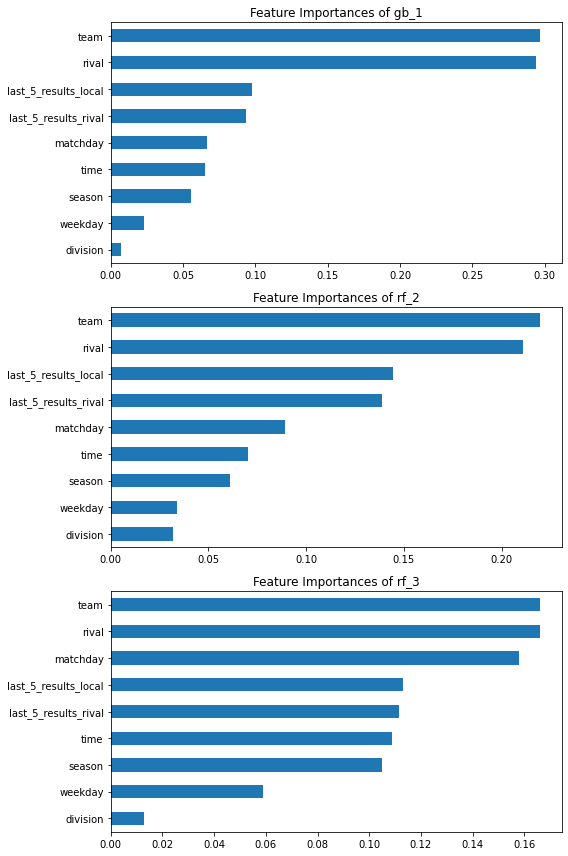

In [44]:
gb_1_importances = pd.Series(gb_model_1.feature_importances_, index=features)
rf_2_importances = pd.Series(rf_model_2.feature_importances_, index=features)
rf_3_importances = pd.Series(rf_model_3.feature_importances_, index=features)

# Create a 3x1 subplot
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 12))

# Plot the first subplot (gb_1)
gb_1_importances.sort_values(ascending=True).plot(kind="barh", ax=axes[0])
axes[0].set_title('Feature Importances of gb_1')

# Plot the second subplot (rf_2)
rf_2_importances.sort_values(ascending=True).plot(kind="barh", ax=axes[1])
axes[1].set_title('Feature Importances of rf_2')

# Plot the third subplot (rf_3)
rf_3_importances.sort_values(ascending=True).plot(kind="barh", ax=axes[2])
axes[2].set_title('Feature Importances of rf_3')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

At first view, it seems as though with this new data the model works the same way, as supposed

In [45]:
voting_model_1 = VotingClassifier(estimators=[('gb', gb_model_1),
                                                ('rf1', rf_model_2),
                                                ('rf2', rf_model_3)],
                                                voting='hard')
voting_model_1.fit(X_train, y_train)
voting_model_1_y_pred = voting_model_1.predict(X_test)
print(f"RMSE: {mean_squared_error(y_test, voting_model_1_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, voting_model_1_y_pred)}")
print(f"R^2: {r2_score(y_test, voting_model_1_y_pred)}")

RMSE: 1.1143473886254804
MAPE: 328108985264445.6
R^2: -0.8159099794803919


For this dataset, we can only test our models with 3 matchdays. It's now useful at all to take decision with this, but let's take a look which model makes better predictions at the firsts matchdays.

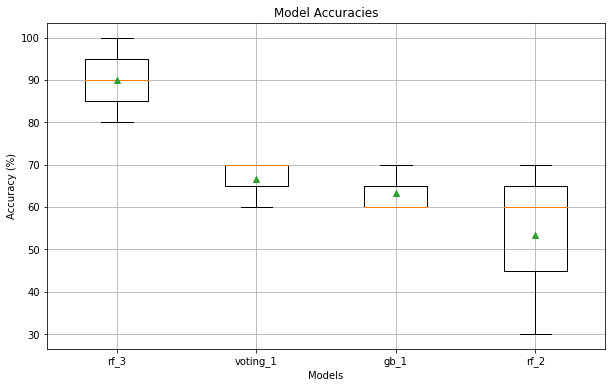

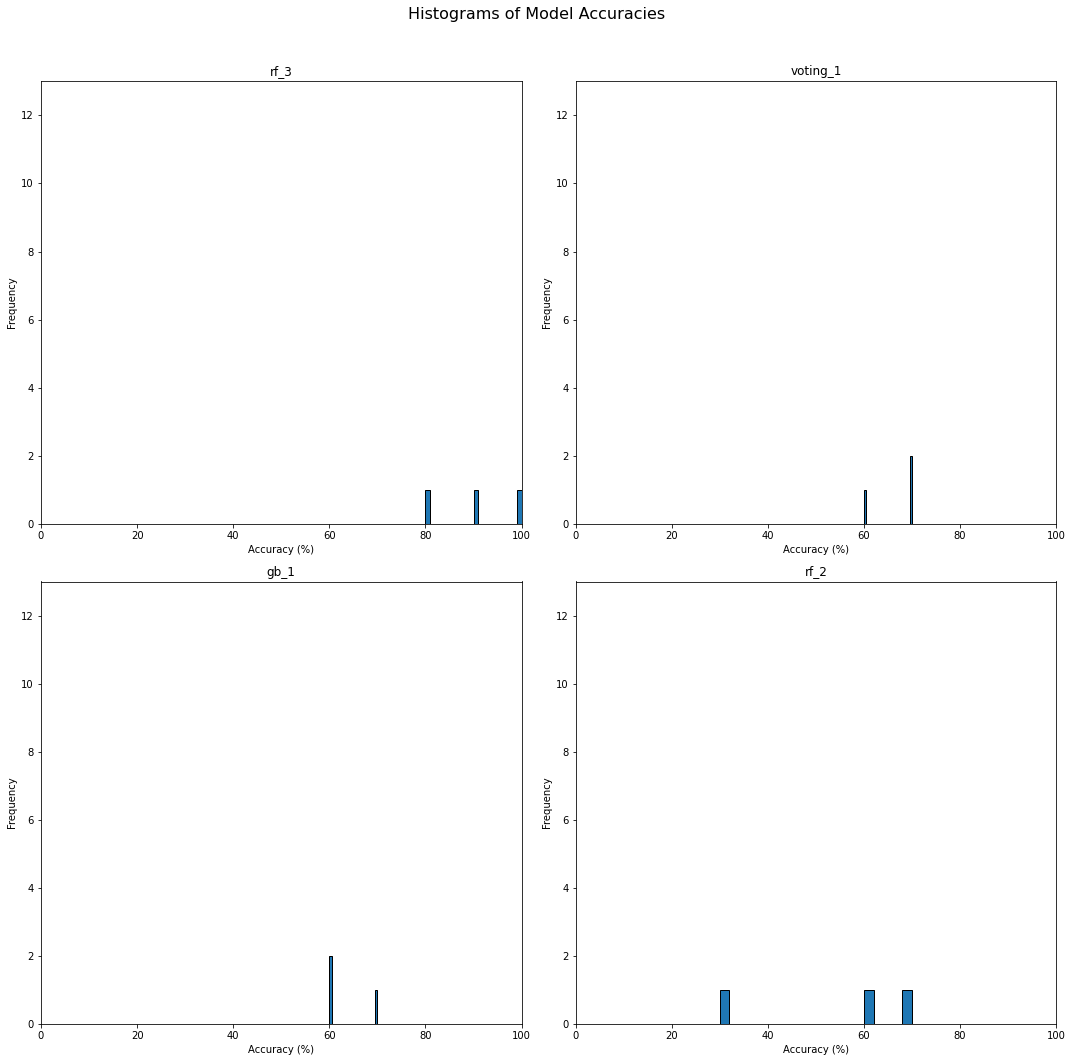

In [47]:
voting_1_accuracies = []
gb_1_accuracies = []
rf_2_accuracies = []
rf_3_accuracies = []
voting_1_total_predictions = []
gb_1_total_predictions = []
rf_2_total_predictions = []
rf_3_total_predictions = []
total_y_results = []

div = 1
matchdays_1 = [i + 1 for i in range(3)]
for matchday in matchdays_1:
    matchday_predict = dataset_predict_1.loc[(dataset_predict_1['division'] == div) & (dataset_predict_1['matchday'] == matchday)]
    X_predict, y_predict = matchday_predict[features], matchday_predict[target]
    voting_1_y_pred = voting_model_1.predict(X_predict)
    gb_1_y_pred = gb_model_1.predict(X_predict)
    rf_2_y_pred = rf_model_2.predict(X_predict)
    rf_3_y_pred = rf_model_3.predict(X_predict)
    
    real_results = y_predict.to_list()
    voting_1_predictions = voting_1_y_pred.tolist()
    gb_1_predictions = gb_1_y_pred.tolist()
    rf_2_predictions = rf_2_y_pred.tolist()
    rf_3_predictions = rf_3_y_pred.tolist()
    total_y_results += real_results
    voting_1_total_predictions += voting_1_predictions
    gb_1_total_predictions += gb_1_predictions
    rf_2_total_predictions += rf_2_predictions
    rf_3_total_predictions += rf_3_predictions
    
    total_matches = len(real_results)
    voting_1_total_predicted = 0
    gb_1_total_predicted = 0
    rf_2_total_predicted = 0
    rf_3_total_predicted = 0
    
    for i in range(total_matches):
        if real_results[i] == voting_1_predictions[i]:
            voting_1_total_predicted += 1
        if real_results[i] == gb_1_predictions[i]:
            gb_1_total_predicted += 1
        if real_results[i] == rf_2_predictions[i]:
            rf_2_total_predicted += 1
        if real_results[i] == rf_3_predictions[i]:
            rf_3_total_predicted += 1
    
    voting_1_accuracies.append(voting_1_total_predicted * 100 / total_matches)
    gb_1_accuracies.append(gb_1_total_predicted * 100 / total_matches)
    rf_2_accuracies.append(rf_2_total_predicted * 100 / total_matches)
    rf_3_accuracies.append(rf_3_total_predicted * 100 / total_matches)

models = ['voting_1', 'gb_1', 'rf_2', 'rf_3']
accuracies = [voting_1_accuracies, gb_1_accuracies,
            rf_2_accuracies, rf_3_accuracies]

mean_accuracies = [mean(acc) for acc in accuracies]

sorted_indices = sorted(range(len(mean_accuracies)), key=lambda k: mean_accuracies[k], reverse=True)
sorted_models = [models[i] for i in sorted_indices]
sorted_accuracies = [accuracies[i] for i in sorted_indices]

# Create a box plot
plt.figure(figsize=(10, 6))
plt.boxplot(sorted_accuracies, labels=sorted_models, showmeans=True)
plt.title('Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.grid(True)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.suptitle('Histograms of Model Accuracies', fontsize=16)

for i in range(2):
    for j in range(2):
        model_index = i * 2 + j
        axes[i, j].hist(sorted_accuracies[model_index], bins=20, edgecolor='black')
        axes[i, j].set_title(sorted_models[model_index])
        axes[i, j].set_xlabel('Accuracy (%)')
        axes[i, j].set_ylabel('Frequency')
        axes[i, j].set_xlim(0, 100)
        axes[i, j].set_ylim(0, 13)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])


plt.show()
    
    

It happens the same as for the last testing with the dataset_predictions_1. The gb_1 model seems better than the rest, even though it is only tested with 3 matchdays now.

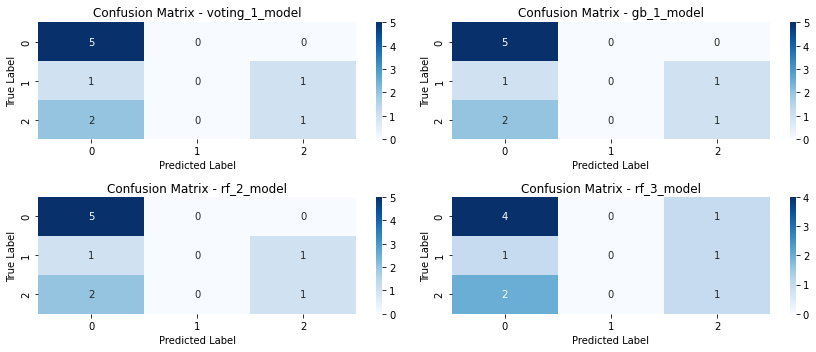

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

voting_1_cm = confusion_matrix(y_predict, voting_1_predictions)
gb_1_cm = confusion_matrix(y_predict, gb_1_predictions)
rf_2_cm = confusion_matrix(y_predict, rf_2_predictions)
rf_3_cm = confusion_matrix(y_predict, rf_3_predictions)

fig, axes = plt.subplots(2, 2, figsize=(12, 5))

# Confusion Matrix for voting_model_1
sns.heatmap(voting_1_cm, annot=True, fmt="d", cmap="Blues", ax=axes[0, 0])
axes[0, 0].set_title('Confusion Matrix - voting_1_model')
axes[0, 0].set_xlabel('Predicted Label')
axes[0, 0].set_ylabel('True Label')

# Confusion Matrix for gb_model_1
sns.heatmap(gb_1_cm, annot=True, fmt="d", cmap="Blues", ax=axes[0, 1])
axes[0, 1].set_title('Confusion Matrix - gb_1_model')
axes[0, 1].set_xlabel('Predicted Label')
axes[0, 1].set_ylabel('True Label')

# Confusion Matrix for rf_model_2
sns.heatmap(rf_2_cm, annot=True, fmt="d", cmap="Blues", ax=axes[1, 0])
axes[1, 0].set_title('Confusion Matrix - rf_2_model')
axes[1, 0].set_xlabel('Predicted Label')
axes[1, 0].set_ylabel('True Label')

# Confusion Matrix for rf_model_3
sns.heatmap(rf_3_cm, annot=True, fmt="d", cmap="Blues", ax=axes[1, 1])
axes[1, 1].set_title('Confusion Matrix - rf_3_model')
axes[1, 1].set_xlabel('Predicted Label')
axes[1, 1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

There is few data to test with, so this confusion matrix doesn't add extra information. Only that for this 3 matchdays, it has a good prediction on the true wins of the local teams. However, for the ties and looses it happens the same as before.

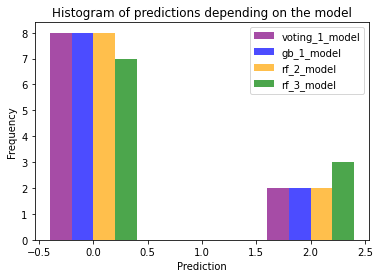

In [ ]:
plt.hist([voting_1_predictions, gb_1_predictions, rf_2_predictions, rf_3_predictions], 
        bins=[-0.5, 0.5, 1.5, 2.5], alpha=0.7, color=['purple', 'blue', 'orange', 'green'])

plt.xlabel('Prediction')
plt.ylabel('Frequency')
plt.title('Histogram of predictions depending on the model')
plt.legend(['voting_1_model', 'gb_1_model', 'rf_2_model', 'rf_3_model'])

plt.show()

None of the models have tried to predict a tie. They only predict around a 20% of looses and the other part they predict the local team is going to win. As expected, this kind of predictions are accompanied with relatively good results of the accuracy.

In fact, for the matchday we want to predict:


In [ ]:
div = 1
matchday = 3
matchday_predict = dataset_predict_2.loc[(dataset_predict_2['division'] == div) & (dataset_predict_2['matchday'] == matchday)]
X_predict, y_predict = matchday_predict[features], matchday_predict[target]
gb_1_y_pred = gb_model_1.predict(X_predict)
real_results = y_predict.to_list()
gb_1_predictions = gb_1_y_pred.tolist()

total_matches = len(real_results)
gb_1_total_predicted = 0

for i in range(total_matches):
    if real_results[i] == gb_1_predictions[i]:
        gb_1_total_predicted += 1
        
gb_1_accuracy = gb_1_total_predicted * 100 / total_matches
print(f"gb_1 model has a {gb_1_accuracy}% accuracy for division {div} and matchday {matchday}\n")

gb_1 model has a 60.0% accuracy for division 1 and matchday 3



CONCLUSION

In conclusion, the model that seems to fit better is the gb_1, which is also the simplier of all. It makes good predictions and, even though that for these last matchdays it is because it try a lot to predict a 0, this same model seem to work better when it has to predict more matches, with some tries on predicting a tie (1). 

What I'd like to see here is what happens if, now that I know which kind of model works better, I train the model with the whole dataset, not only a portion.

In [ ]:
features = ['season', 'division', 'matchday', 'weekday', 'time', 'team', 'rival', 'last_5_results_local','last_5_results_rival']
target = "winner"
X, y = dataset_2[features], dataset_2[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=1)

In [ ]:
gb_model_1 = GradientBoostingClassifier()
gb_model_1.fit(X_train, y_train)
gb_model_1_y_pred = gb_model_1.predict(X_test)
print(f"RMSE: {mean_squared_error(y_test, gb_model_1_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, gb_model_1_y_pred)}")
print(f"R^2: {r2_score(y_test, gb_model_1_y_pred)}")

RMSE: 1.0827805840074194
MAPE: 397947380866789.8
R^2: -0.7573922064178344


In [ ]:
def preparing_predicting_dataset_2():
    data = io.load_historical_data("all")
    data = data.loc[data['season'] == "2021-2022"]
    data[['local_goals', 'visitor_goals']] = data['score'].str.split(':', expand=True).astype(float)
    data['winner'] = data.apply(determine_winner, axis=1)
    data['goal_difference'] = data['local_goals'] - data['visitor_goals']
    data['weekday'] = data['date'].apply(weekday_match)
    
    home_team_df = data.copy()
    home_team_df['team'], home_team_df['rival'], home_team_df['condition'] = home_team_df['home_team'], home_team_df['away_team'], 'local'
    away_team_df = data.copy()
    away_team_df['team'], away_team_df['rival'], away_team_df['condition']= away_team_df['away_team'], away_team_df['home_team'], 'visitor'
    
    matches_data = pd.concat([home_team_df, away_team_df], ignore_index=True).sort_values(by=['season', 'division', 'team', 'matchday'])
    matches_data.reset_index(drop=True, inplace=True)
    
    matches_data['GF_match'] = matches_data.apply(lambda row: row['local_goals'] if row['condition'] == 'local' else row['visitor_goals'], axis=1)
    matches_data['GA_match'] = matches_data.apply(lambda row: row['visitor_goals'] if row['condition'] == 'local' else row['local_goals'], axis=1)
    matches_data['GD_match'] = matches_data['GF_match'] - matches_data['GA_match']
    matches_data['W_match'] = ((matches_data['winner'] == 'Local') & (matches_data['condition'] == 'local')) | ((matches_data['winner'] == 'Visitor') & (matches_data['condition'] == 'visitor'))
    matches_data['L_match'] = ((matches_data['winner'] == 'Visitor') & (matches_data['condition'] == 'local')) | ((matches_data['winner'] == 'Local') & (matches_data['condition'] == 'visitor'))
    matches_data['T_match'] = (matches_data['winner'] == 'Tie')
    matches_data['match_result'] = matches_data.apply(match_result, axis=1)
    matches_data['last_match_result_1'] = matches_data.groupby(['season', 'team'])['match_result'].shift(1)
    matches_data['last_match_result_2'] = matches_data.groupby(['season', 'team'])['match_result'].shift(2)
    matches_data['last_match_result_3'] = matches_data.groupby(['season', 'team'])['match_result'].shift(3)
    matches_data['last_match_result_4'] = matches_data.groupby(['season', 'team'])['match_result'].shift(4)
    matches_data['last_match_result_5'] = matches_data.groupby(['season', 'team'])['match_result'].shift(5)
    matches_data['last_5_results_local'] = matches_data[['last_match_result_1', 'last_match_result_2', 'last_match_result_3', 
                                                'last_match_result_4', 'last_match_result_5']].values.tolist()

    matches_data['GF'] = matches_data.groupby(['season', 'team'])['GF_match'].cumsum()
    matches_data['GA'] = matches_data.groupby(['season', 'team'])['GA_match'].cumsum()
    matches_data['W'] = matches_data.groupby(['season', 'team'])['W_match'].cumsum()
    matches_data['L'] = matches_data.groupby(['season', 'team'])['L_match'].cumsum()
    matches_data['T'] = matches_data.groupby(['season', 'team'])['T_match'].cumsum()
    
    final_ranking = matches_data.reset_index()
    final_ranking['GD'] = final_ranking['GF'] - final_ranking['GA']
    final_ranking['Pts'] = final_ranking['W'] * 3 + final_ranking['T']
    final_ranking = final_ranking.sort_values(by=['season', 'division', 'matchday', 'Pts', 'GD'], ascending=[False, True, True, False, False])
    final_ranking.reset_index(drop=True, inplace=True)
    final_ranking['rank'] = final_ranking.groupby(['season', 'division', 'matchday'])['Pts'].rank(ascending=False, method='first').astype(int)
    
    final_ranking = final_ranking[['season', 'division', 'matchday', 'weekday', 'time', 'rank', 'team', 'rival', 'condition', 'winner', 'GF_match', 'GA_match', 'GD_match', 'GF', 'GA', 'GD', 'W', 'L', 'T', 'Pts', 'last_5_results_local']]
    ### Prepare numerical data
    #season
    final_ranking['season'] = final_ranking['season'].replace("2021-2022", 2021)
    #time
    final_ranking['time'] = final_ranking['time'].apply(numerical_time)
    #team / rival
    team_names = final_ranking['team'].unique()
    team_ids = [i for i in range(len(team_names))]
    final_ranking[['team', 'rival']] = final_ranking[['team', 'rival']].replace(team_names, team_ids)
    
    #winner --> 0: Local, 1: Tie, 2:Visitor
    final_ranking['winner'] = final_ranking['winner'].replace(['Local', 'Tie', 'Visitor'], [0, 1, 2])
    #last 5 results
    final_ranking['last_5_results_local'] = final_ranking['last_5_results_local'].apply(numerical_last_results_local)
    mapping = final_ranking.groupby(['season', 'matchday']).apply(lambda x: dict(zip(x['team'], x['last_5_results_local']))).to_dict()
    final_ranking['last_5_results_rival'] = final_ranking.apply(lambda row: mapping.get((row['season'], row['matchday']), {}).get(row['rival'], None), axis=1)
    # The matches are repeated: Drop when condition is Visitor
    final_ranking = final_ranking.loc[final_ranking['condition'] == 'local']

    final_ranking.to_excel('./analysis/predicting_dataset_2.xlsx')
    return final_ranking


# Aux function
def weekday_match(date):
    month, day, year = map(int, date.split('/'))
    year += 2000
    
    n_weekday = datetime.date(year, month, day).weekday()
    return n_weekday

def determine_winner(row):
    if row['local_goals'] > row['visitor_goals']:
        return 'Local'
    elif row['local_goals'] < row['visitor_goals']:
        return 'Visitor'
    else:
        return 'Tie'
    
def match_result(row):
    if row['W_match'] == True:
        return 'W'
    elif row['L_match'] == True:
        return 'L'
    elif row['T_match'] == True:
        return 'T'
    
def numerical_time(time_string):
    if time_string is None:
        time_string = "12:00 AM"
    time_parts = datetime.datetime.strptime(time_string, "%I:%M %p")
    time_num = time_parts.hour + time_parts.minute / 60
    return time_num

def numerical_last_results_local(last_results_list):
    total = 0
    for result in last_results_list:
        if result == 'W':
            total += 3
        elif result == 'T':
            total += 1
        else:
            total += -3
    return total

dataset_predict_2 = preparing__predicting_dataset_2()

<AxesSubplot:>

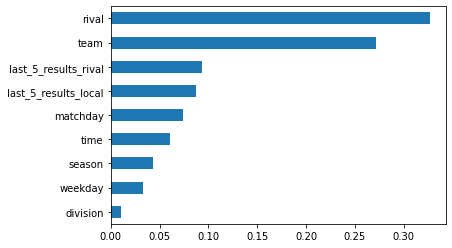

In [ ]:
gb_1_importances = pd.Series(gb_model_1.feature_importances_, index=features)
gb_1_importances.sort_values(ascending=True).plot(kind="barh")

In [ ]:
div = 1
matchday = 3
matchday_predict = dataset_predict_2.loc[(dataset_predict_2['division'] == div) & (dataset_predict_2['matchday'] == matchday)]
X_predict, y_predict = matchday_predict[features], matchday_predict[target]
gb_1_y_pred = gb_model_1.predict(X_predict)
real_results = y_predict.to_list()
gb_1_predictions = gb_1_y_pred.tolist()

total_matches = len(real_results)
gb_1_total_predicted = 0

for i in range(total_matches):
    if real_results[i] == gb_1_predictions[i]:
        gb_1_total_predicted += 1
        
gb_1_accuracy = gb_1_total_predicted * 100 / total_matches
print(f"gb_1 model has a {gb_1_accuracy}% accuracy for division {div} and matchday {matchday}\n")

gb_1 model has a 60.0% accuracy for division 1 and matchday 3



The accuracy doesn't change at all